<a href="https://colab.research.google.com/github/LucianoTrujillo/7506R-2C2022-GRUPO10/blob/main/7506R_TP2_GRUPO10_ENTREGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#**TP2: Propiedades en Venta**



---


---


## *Facultad de Ingeniería, Universidad de Buenos Aires*

---
### *2do Cuatrimestre de 2022*

---
### *Organización de Datos*

### *Curso: Rodriguez*

### *Integrantes:*

* Luciano Leon Trujillo Palomo ltrujillo@fi.uba.ar 105664
* María Pilar Gaddi mgaddi@fi.uba.ar 105682
* Federico Adrian Solari Vazquez fsolariv@fi.uba.ar 106895
* Maria Vazquez Navarro mvazquezn@fi.uba.ar 105576
* Mateo Bulnes mbulnes@fi.uba.ar 106211
---

## **Objetivo del trabajo**

---
---

Los conjuntos de datos a utilizar properati_argentina_2021 y properati_argentina_2021_decrip
se encuentran disponibles en el siguiente enlace, la descripción de las variables se encuentra
disponible aquí . Para este trabajo se plantean los siguientes objetivos generales:
- Procesamiento del Lenguaje Natural: el objetivo será analizar las descripciones de los avisos para construir nuevos features y reentrenar algunos modelos del TP1.
- Redes Neuronales: se deberán implementar dos modelos de red neuronal uno para
clasificación y otro para regresión.
- Ensamble de Modelos: el objetivo será construir dos ensambles híbridos uno para clasificación y otro para regresión pudiendo utilizar los modelos del TP1

---





## **Setup previo**


Importamos todas las librerías a utilizar a lo largo del trabajo.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import sklearn as sk
from sklearn import datasets
import collections
from importlib import reload
import re

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression 

In [ ]:
#Clasificadores
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import  VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegressionCV

from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from collections import defaultdict

import plotly.graph_objects as go

np.random.seed(4)

In [ ]:
#Modelos
from sklearn import tree
from sklearn.tree import export_text
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, recall_score, accuracy_score,f1_score
from sklearn.tree import export_graphviz
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import hyperopt
from hyperopt import tpe, fmin
from hyperopt import hp

Importamos el dataset original y lo guardamos para su posterior uso.

In [ ]:
dwn_url='https://drive.google.com/uc?id=1QOcQ3hOhzxadj34y_wcvwYNa0-fNrmn3'
ds_original = pd.read_csv(dwn_url)

Importamos el dataset que contiene las descripciones. Para ello previamente separamos el dataset en dos conjuntos donde uno contiene todas las filas del split train y otro del test.

In [ ]:
dwn_url_descrip_train='https://drive.google.com/uc?id=1d41f4YY2KC-rZ0DHR3izgB2jVaxyFs1r'
ds_descrip_train = pd.read_csv(dwn_url_descrip_train)

dwn_url_descrip_test='https://drive.google.com/uc?id=1L4zk4ektIEgeMMnhWXclzrHsK1o4EyKD'
ds_descrip_test = pd.read_csv(dwn_url_descrip_test)

In [ ]:
x_train = pd.read_csv('https://drive.google.com/uc?id=1sOpD9HgOjs6LzVEksLAX8-4AEbP4-wzh')
x_test = pd.read_csv('https://drive.google.com/uc?id=1S8sI6QdQalkiUJg8mT_dO00_TO_WvGKQ')

y_train = pd.read_csv('https://drive.google.com/uc?id=1r9yX8AecV66Ya2UJi4IbPB2JVo_gwT2S')
y_test = pd.read_csv('https://drive.google.com/uc?id=112e7sRozO0YRRjgdOJxEXfiVuhJ0xSvl')

In [ ]:
x_train_target = pd.read_csv('https://drive.google.com/uc?id=1xVlHoR4jXTNdOslM5W0Tvciz-qagN5x0')

x_test_target = pd.read_csv('https://drive.google.com/uc?id=1QgQmGjIwzMckA84GlNt26WmVoLbuHbwV')

Eliminamos la primer columna que hace referencia a los indices que tenia cuando se exporto el dataset. 


In [ ]:
x_train = x_train.iloc[:,1:20]
x_test = x_test.iloc[:,1:20]

In [ ]:
x_train_target=x_train_target.iloc[:,1:10]
x_test_target=x_test_target.iloc[:,1:10]

In [ ]:
ds_descrip_train = ds_descrip_train.iloc[:,1:3]
ds_descrip_test = ds_descrip_test.iloc[:,1:3]

Para faciliar los analisis creamos datasets como los de x_train y test, pero que tengan la columna de descripcion.

In [ ]:
x_train_con_desc=pd.merge(x_train, ds_descrip_train, how='left', on='id')
x_test_con_desc=pd.merge(x_test, ds_descrip_test, how='left', on='id')

Ahora que mergemos siguiendo el id de cada propiedad, podemos quedarnos solo con las descripciones en nuestro data set de ds_descrip_*.

In [ ]:
ds_descrip_train = x_train_con_desc[['property_description']]
ds_descrip_test = x_test_con_desc[['property_description']]

Asignamos los y_train y test obteniendo el property_price de los datasets corresponientes. 

In [ ]:
y_train = y_train.property_price
y_test = y_test.property_price

### Creacion de data set con cada palabra

Para un analisis posterior decidimos crear un dataset que por cada fila tenga cada palabra de su descripcion, manteniendo los respectivos indices.

Primero creamos un nuevo data frame para obtener la frecuencia de las palabras en cada una de las descripciones. Este dataframe se forma de manera tal que cada fila contiene cada palabra de las descripción correspondiente, conservando los valores de los demás features. 

In [ ]:
ds_descrip_train

,property_description
0,Formando parte del Barrio Catalinas Sur: Carac...
1,Luminoso 4 ambientes<br><br>2 dormitorios ampl...
2,"Se trata de un PH de 2 ambientes con patio, po..."
3,Corredor Responsable: Cristian Arnal Ponti - C...
4,Corredor Responsable: Micaela Perez / Lucas Fe...
...,...
63362,Venta DEPARTAMENTO 2 Ambientes Villa Urquiza. ...
63363,Amplio y luminoso monoambiente a contrafrente ...
63364,"VENTA Monoambiente divisible, con balcón al co..."
63365,Departamento de 3 ambientes MUY LUMINOSO al fr...


In [ ]:
ds_cada_palabra_train = ds_descrip_train.copy()
ds_cada_palabra_test = ds_descrip_test.copy()

In [ ]:
ds_cada_palabra_train.property_description = ds_descrip_train.property_description.str.split()
ds_cada_palabra_test.property_description = ds_descrip_test.property_description.str.split()

In [ ]:
ds_cada_palabra_train = ds_cada_palabra_train.explode('property_description')
ds_cada_palabra_test = ds_cada_palabra_test.explode('property_description')

In [ ]:
ds_cada_palabra_train = ds_cada_palabra_train.reset_index()
ds_cada_palabra_test = ds_cada_palabra_test.reset_index()

Observamos que en cada entrada de nuestro dataset tendremos cada palabra de las respectivas descripciones. Vemos como las primeras 5 entradas hacen referencia a la primer descripcion, por eso tiene el mismo id. 

In [ ]:
ds_cada_palabra_train.head(5)

,index,property_description
0,0,Formando
1,0,parte
2,0,del
3,0,Barrio
4,0,Catalinas


Modificamos las palabras que presentan mayúsculas para que únicamente comiencen con letras minúsculas. 

In [ ]:
ds_cada_palabra_train['property_description'] = ds_cada_palabra_train['property_description'].str.lower()
ds_cada_palabra_test['property_description'] = ds_cada_palabra_test['property_description'].str.lower()

In [ ]:
ds_cada_palabra_train.rename(columns = {'property_description':'palabra', 'index':'indice'}, inplace = True)
ds_cada_palabra_test.rename(columns = {'property_description':'palabra', 'index':'indice'}, inplace = True)

## Glosario: 

* x_train: Dataset para entrenamiento con todos los features originales.
* x_test: Dataset para testeo con todos los features originales.
* x_train_target: Dataset con los features que nos parecieron relevantes para entrenar los modelos.
* x_test_target: Dataset con los features que nos parecieron relevantes para testear los modelos.
* ds_descrip_train: Dataset con las descripciones de cada registro del entrenamiento.
* ds_descrip_test: Dataset con las descripciones de cada registro de testeo.
* x_train_con_desc: Dataset que contiene las columnas de descripcion para entrenamiento con todos los features originales.
* x_test_con_desc: Dataset que contiene las columnas de descripcion para testeo con todos los features originales.
* y_train: Precio del entrenamiento.
* y_test: Precio del testeo.
* ds_cada_palabra_train: Data set que tiene en cada fila cada palabra usada por las respectivas descripciones de entranamiento, manteniendo los indices. 
* ds_cada_palabra_test: Data set que tiene en cada fila cada palabra usada por las respectivas descripciones de testeo, manteniendo los indices. 

In [ ]:
x_train.head(1)

,id,latitud,longitud,place_l2,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title,pxm2,tipo_precio_1,tipo_precio_2,tipo_precio_generico
0,rL7qPkQnomsMGu2ViS3sBw==,-34.628647,-58.361871,Capital Federal,Boca,Venta,Departamento,4.0,3.0,70.0,70.0,99000.0,USD,Departamento - 4 Ambientes - Catalinas Sur,1414.0,low_price,low_price,low_price


In [ ]:
x_train_target.head(1)

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_type_Casa,property_type_Departamento,property_type_PH
0,-34.628647,-58.361871,4.0,3.0,70.0,70.0,0,1,0


In [ ]:
x_train_con_desc.head(1)

,id,latitud,longitud,place_l2,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title,pxm2,tipo_precio_1,tipo_precio_2,tipo_precio_generico,property_description
0,rL7qPkQnomsMGu2ViS3sBw==,-34.628647,-58.361871,Capital Federal,Boca,Venta,Departamento,4.0,3.0,70.0,70.0,99000.0,USD,Departamento - 4 Ambientes - Catalinas Sur,1414.0,low_price,low_price,low_price,Formando parte del Barrio Catalinas Sur: Carac...


In [ ]:
y_train.head(1)

0    99000.0
Name: property_price, dtype: float64

In [ ]:
y_test.head(1)

0    82900.0
Name: property_price, dtype: float64

In [ ]:
x_train_con_desc.head(1)

,id,latitud,longitud,place_l2,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title,pxm2,tipo_precio_1,tipo_precio_2,tipo_precio_generico,property_description
0,rL7qPkQnomsMGu2ViS3sBw==,-34.628647,-58.361871,Capital Federal,Boca,Venta,Departamento,4.0,3.0,70.0,70.0,99000.0,USD,Departamento - 4 Ambientes - Catalinas Sur,1414.0,low_price,low_price,low_price,Formando parte del Barrio Catalinas Sur: Carac...


In [ ]:
x_test_con_desc.head(1)

,id,latitud,longitud,place_l2,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title,pxm2,tipo_precio_generico,property_description
0,d3Z0MblSb2IMBoOBMGJEEQ==,-34.637319,-58.361124,Capital Federal,Boca,Venta,Departamento,3.0,2.0,58.0,55.0,82900.0,USD,VENTA TRES AMBIENTES LA BOCA PISO ALTO,1429.0,low_price,Corredor Responsable: Gustavo Guastello - C.U....


In [ ]:
ds_cada_palabra_train.head(5)

,indice,palabra
0,0,formando
1,0,parte
2,0,del
3,0,barrio
4,0,catalinas


In [ ]:
ds_cada_palabra_test.head(5)

,indice,palabra
0,0,corredor
1,0,responsable:
2,0,gustavo
3,0,guastello
4,0,-


In [ ]:
# función auxiliar para mostrar gráficos completos 
def mostrar_metadata_grafico(titulo, ylabel=None, xlabel=None, leyendas=None):
  plt.title(titulo)
  if ylabel:
    plt.ylabel = ylabel
  if xlabel:
    plt.xlabel = xlabel
  if leyendas:
    plt.legend = leyendas
  plt.show()

# Ampliación del dataset

Utilizaremos la columna descripción para encontrar aspectos de una propiedad. Luego utilizaremos esos aspectos para crear nuevas columnas y ampliar el detaset original.

Definimos una nueva función buscar_palabra para que se puedan buscar palabras (en el dataset que se pase por parametro) en una columna específica. 

In [ ]:
def buscar_palabra(ds=ds_cada_palabra_train,nombre=None):
  ds_palabra_buscada = ds[0:0]#creo el ds en estado vacio pero conservo las columnas
  for i in range(len(nombre)):
    con_coma_despues = nombre[i]+',' # concateno una coma

    ds_post_coma = ds[(ds['palabra'] == con_coma_despues)] # filtro por palabra buscada
    ds_aux = ds[(ds['palabra'] == nombre[i])]              # filtro por palabra buscada con coma 
    ds_palabra_buscada = pd.concat([ds_palabra_buscada, ds_aux, ds_post_coma])  #concateno ambos ds filtrados formando uno solo

  return ds_palabra_buscada

Definimos una nueva función mostrar_frecuencias para poder graficar las frecuencias de ciertas palabras en un dataset. 

In [ ]:
def mostrar_frecuencias(df, columna='palabra', ancho=25, alto=10):
    frecuencia_por_valor = df.groupby(columna).size().to_frame("frecuencia")
    frecuencia_por_valor = frecuencia_por_valor.sort_values(by="frecuencia", ascending=False).reset_index()
    frecuencia_por_valor.head(40).plot.bar(x=columna, y="frecuencia", figsize=(ancho, alto))
    mostrar_metadata_grafico(f"frecuencias de valores posibles de {columna}", ylabel="frecuencia", xlabel="valores posibles")

## Procesamiento del Lenguaje Natural

#### Análisis de frecuencias 

En principio, analizaremos las frases o valores repetidos.

Para filtrar palabras comunmente conocidas en las descripciones de una propiedad creamos un arreglo de palabras en las cuales no queremos detenerlos por el momento. La idea es encontrar frecuencias altas de palabras que nos puedan cambiar en el analisis.

Agregamos ciertas palabras comunes presentes en las descripciones de cada propiedad. Dentro de este grupo se encuentran preposiciones, numeros, signos de puntación, entre otros.

In [ ]:
palabras_comunes = [',', '.','a', 'ante', 'bajo', 'cabe', 'con', 'contra', 'de', 'desde', 'durante', 'en', 'entre', 'hacia', 'hasta','mediante', 'para', 'por', 'según', 'sin', 'so', 'sobre', 'tras', 'versus', 'vía', 'y', 'el', 'o', 'la', 'del', 'al', 'que', 'un', 'las', 'los', 'se', 'una', 'son', 'es', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
'casa', 'departamento', 'ph', 'dos', 'tres', 'cuatro', 'cinco', 'seis', 'siete','1','1°','1er', '2', '2°', '2do','3', '3°', '3er','4', '4°', '4to','5', '5°', '5to','6', '6°', '6to','7', '7°', '7mo','8', '8°', '8vo',
'9', '9°', '9no','10', '10°', '10mo','11', '11°','primer','segundo', 'tercer', 'cuarto', 'quinto','sexto', 'septimo', 'octavo', 'noveno', 'decimo', '-', '_', 'no', 'ambientes',
'muy', 'x', 'tu', '/', 'dormitorio', 'valor', 'esta', 'corredor', 'inmueble', 'edificio', 'responsable:', ':', '<br>', '...', 'hs', 'master', 'medidas', 'propiedad.', 'cuenta', 'excelente', '\n\n', '#',
 'm2', 'querés!', 'podés.', 'personas', 'encuentra', 'ley', 'dormitorios', 'id', 'comprá', '\n\n ', '<br>', 'seg', 'accede', 'ser', 'su', 'propiedad', 'accedé', 'todos', 'metros',
  'venta', 'barrio', 'zona', 'lo', 'como', 'todo', 'tiene', 'puede', 'operación', 'operaciones','propietario', 'valores', '__________________________________________________________________________', '____________________________estado']

Filtraremos aquellas palabras que tengan una frecuencia de 1, las palabras comunes mencionadas arriba, y unas /n/n que encontramos haciendo el analisis.

In [ ]:
barras_n = ds_cada_palabra_train[ds_cada_palabra_train['palabra'].map(ds_cada_palabra_train['palabra'].value_counts()) == 18119].palabra.values # palabras /n de diferentes tipos
frec_igual_a_uno = ds_cada_palabra_train[ds_cada_palabra_train['palabra'].map(ds_cada_palabra_train['palabra'].value_counts()) == 1].palabra.values

In [ ]:
ds_sin_palabras_comunes = ds_cada_palabra_train[~ds_cada_palabra_train.palabra.isin(palabras_comunes)]
ds_sin_palabras_comunes = ds_sin_palabras_comunes[~ds_sin_palabras_comunes.palabra.isin(barras_n)]
ds_sin_palabras_comunes = ds_sin_palabras_comunes[~ds_sin_palabras_comunes.palabra.isin(frec_igual_a_uno)]

Se analizará la frecuencia de las palabras en el dataset, evitando aquellas que son muy comunes en las descripciones de las propiedades.

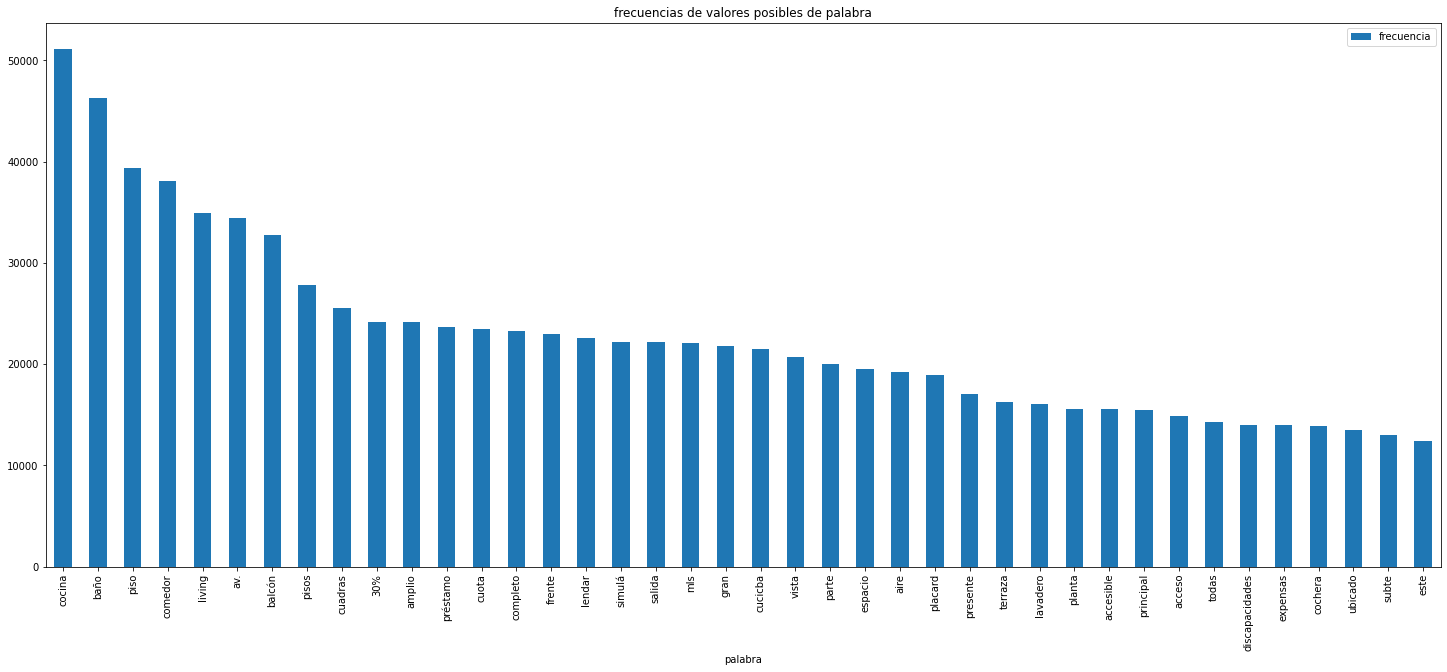

In [ ]:
mostrar_frecuencias(ds_sin_palabras_comunes)

Una vez analizada la frecuencia de las palabras anteriores, nos dimos cuenta que encontramos palabras que son obvias en una descripcion que no se nos habian ocurrido antes. Decidimos eliminarlas y repetir el analisis.

In [ ]:
palabras_obvias = ['cocina', 'baño', 'piso', 'comedor', 'living', 'balcon', 'pisos', 'amplio', 'gran', 'vista', 'aire', 'terraza', 'metros', 'placard',
                   'lavadero','planta', 'patio', 'balcón', 'cochera']
ds_sin_palabras_obvias = ds_sin_palabras_comunes[~ds_sin_palabras_comunes.palabra.isin(palabras_obvias)]

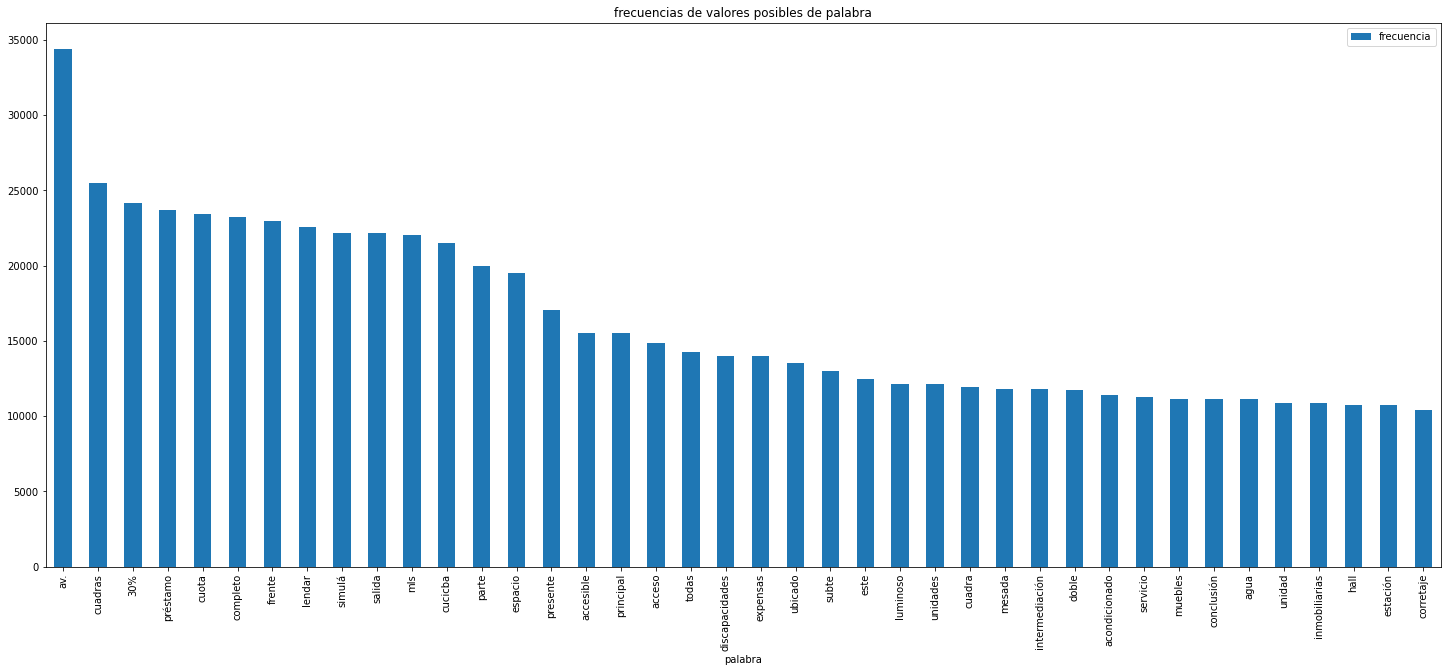

In [ ]:
mostrar_frecuencias(ds_sin_palabras_obvias)

Nos llamo la atencion que la palabra "simula" tiene una muy alta frecuencia, por lo tanto analizaremos sus palabras contiguas para entender la razón de su elevada frecuencia.

In [ ]:
ds_simula = buscar_palabra(nombre=['simulá'])
indices_simula = ds_simula.index

simula_mas_1=ds_cada_palabra_train.loc[indices_simula+1]
simula_mas_2=ds_cada_palabra_train.loc[indices_simula+2]
simula_mas_3=ds_cada_palabra_train.loc[indices_simula+3]
simula_mas_4=ds_cada_palabra_train.loc[indices_simula+4]

print('-------------------------------------------------')
print("Simula + ...")
print(simula_mas_1.palabra.value_counts().head(3))
print('-------------------------------------------------')
print("Simula + ... + ...")
print(simula_mas_2.palabra.value_counts().head(3))
print('-------------------------------------------------')
print("Simula + ... + ... + ...")
print(simula_mas_3.palabra.value_counts().head(3))
print('-------------------------------------------------')
print("Simula + ... + ... + ... + ...")
print(simula_mas_4.palabra.value_counts().head(3))


-------------------------------------------------
Simula + ...
tu    22192
Name: palabra, dtype: int64
-------------------------------------------------
Simula + ... + ...
cuota       22144
préstamo       27
crédito        12
Name: palabra, dtype: int64
-------------------------------------------------
Simula + ... + ... + ...
en            22147
ingresando       25
\n\n              4
Name: palabra, dtype: int64
-------------------------------------------------
Simula + ... + ... + ... + ...
lendar        22095
a                25
lendartoda       16
Name: palabra, dtype: int64


Vemos que en la mayoria de los casos en los cual aparece la palabra "simulá" en una descripcion, termina formando la frase "Simulá tu cuota en Lendar".

Al investigar encontramos que Lendar conecta directamente a personas que necesitan fondos para comprar o refaccionar su casa con personas que tienen disponibilidad de fondos para invertir.

#### Análisis de frecuencias de posibles features

Definimos los amenities que se pueden llegar a tener en un departamento para luego buscar estas palabras en el dataset original y crear un dataset de amenities, donde se tiene por cada fila el id que tenga dicho amenity.

In [ ]:
amenities = ['gym', 'gimnasio', 'spa', 'jacuzzi', 'pileta', 'piscina', 'alberca', 'solarium', 'sum', 'quincho', 'sauna', 'lavadero', 'baulera', 'atico', 'ático', 'altillo', 'sotano', 'sótano', 'parrilla', 'garage', 'cochera', 'estacionamiento']
ds_amenities = buscar_palabra(nombre=amenities)

In [ ]:
ds_amenities.head(5)

,indice,palabra
7256,36,gym
40935,205,gym
45056,226,gym
48443,242,gym
103698,485,gym


In [ ]:
print(f"Hay " + str(ds_amenities.shape[0]) + " filas con amenities")

Hay 91338 filas con amenities


Realizamos el mismo procedimiento con las palabras "terraza", "patio" y sus palabras relacionadas, creando un nuevo dataset de patio_balcon

In [ ]:
ds_patio_balcon = buscar_palabra(nombre=['terraza', 'patio', 'jardin', 'jardín', 'balcon', 'balcón'])

In [ ]:
ds_patio_balcon.head(5)

,indice,palabra
457,3,terraza
540,3,terraza
1806,10,terraza
3979,17,terraza
5914,26,terraza


In [ ]:
print(f"Hay " + str(ds_patio_balcon.shape[0]) + " filas con balncon o sinonimos")

Hay 81916 filas con balncon o sinonimos


Seguimos buscando a ver cuanto se repiten las siguientes palabras.

In [ ]:
buscar_palabra(nombre=['luminoso','sol', 'luz', 'luminosidad', 'solar']).shape[0]

31632

In [ ]:
buscar_palabra(nombre=['expensas']).shape[0]

22157

In [ ]:
buscar_palabra(nombre=['seguridad','vigilancia', 'camaras', 'porteria', 'portería', 'camara', 'cámara', 'cámaras', 'alarma', 'prosegur', 'portero', 'encargado', 'guardia' ]).shape[0]

18387

In [ ]:
buscar_palabra(nombre=['amueblado','placard','armario','armarios','ropero','roperos','vestidor']).shape[0] 

28184

In [ ]:
buscar_palabra(nombre=['piso','pb']).shape[0] 

46426

In [ ]:
buscar_palabra(nombre=['nuevo','estrenar']).shape[0]

10309

In [ ]:
buscar_palabra(nombre=['metrobus','subte','colectivo','tren','estacion','estación']).shape[0] 

32365

Por ahora no encontramos una presencia muy fuerte de las palabras. Procedemos a analizar la correlacion de los features con el precio. 

## Análisis de correlación de features

In [ ]:
def eliminar_palabras_comunes(texto):
    
    texto = texto.lower()
    texto = texto.replace('<br>', ' ')
    # digito que podría o no tener "hs" o "do" o "er" o "avo" o "to" al final, por ejemplo 10hs o 10
    texto = re.sub(r'\d+(?:hs|do|er|avo|to)?', ' ', texto)

    for palabra in palabras_comunes:
        # reemplazamos la palabra por un espacio en blanco, si la palabra está entre 2 espacios 
        texto = texto.replace(' ' + palabra + ' ', ' ')

    return texto

x_train_for_word_correlation = x_train_con_desc[:5000].copy()

# aplicar funcion para cada fila del dataset x_train
x_train_for_word_correlation['property_description'] = x_train_for_word_correlation['property_description'].apply(eliminar_palabras_comunes)

En la siguiente seccion decidimos analizar la correlacion que tienen las distintas palabras en las descripciones con el precio.
Debido a problemas con las RAM no pudimos examinar absolutamente todos los registros, tuvimos que tomar una muestra mucho menor al tamaño total, como se puede ver agarramos los primeros 5000. 

Sabemos que al tomar los datos de esta forma podemos estar sesgandonos por algun motivo ajeno a los datos (orden de imputacion, etc), en vez de, por ejemplo, tomar una muestra de forma mas aleatoria. Sin embargo, decidimos quedarnos con estos resultados siendo que encontramos una correlacion suficientemente significativa como para considerarlos como potenciales features.  

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# use only 10 rows for testing

# initialize the CountVectorizer
vectorizer = CountVectorizer()

# fit the vectorizer on the descriptions
descriptions = vectorizer.fit_transform(x_train_for_word_correlation['property_description'])

# convert the descriptions to a DataFrame
descriptions = pd.DataFrame(descriptions.toarray(), columns=vectorizer.get_feature_names())
columns=vectorizer.get_feature_names()


y_train_testing = y_train[:5000].copy()
# calculate the correlation of each feature of descriptions with the target y_train
correlations = descriptions.corrwith(y_train_testing, method='pearson')

# sort the correlations by their absolute value
correlations = correlations.sort_values(ascending=False)
# leave only those which are above a certain threshold (0.4) 

In [ ]:
corr = correlations.copy()
corr = corr[corr > 0.3]
for i in corr.index:
    print(i, corr[i])

suite 0.5156504884178066
privado 0.43171209046766473
palier 0.412514862507687
diario 0.39042579280787354
vestidor 0.38107068625214413
toilette 0.3674510010562824
servicio 0.3547763261947496
recepción 0.32656704369199013
comedor 0.31761952150186784
dependencia 0.3144722326608654
playroom 0.3061084280675854


Como vemos, encontramos features con una correlación significativa con el precio de la propiedad. Por esta razón, decidimos agregarlos al dataset, como por ejemplo: suite, palier y vestidor. 

In [ ]:
features_to_add = [ 'suite', 'palier', 'vestidor', 'toilette', 'recepción', 'playroom']

In [ ]:
for feature in features_to_add: 
  x_train[feature] = x_train_con_desc['property_description'].str.contains(feature).map({True: 1, False: 0})
  x_test[feature] = x_test_con_desc['property_description'].str.contains(feature).map({True: 1, False: 0})

#### Creación de Features 

In [ ]:
x_train_features_nuevos = x_train.copy()
x_test_features_nuevos = x_test.copy()

In [ ]:
# ds_a_modificar es el dataset al que le agreamos el feature
def crear_nuevo_feature(ds_a_modificar,nombre_feature, ds, crear_de_cero = True, valor=None):
  if(crear_de_cero):
    ds_a_modificar[nombre_feature] = ds_a_modificar['property_currency'].values # Creamos un nuevo feature como copia de uno existente
    ds_a_modificar.loc[:, nombre_feature].replace(to_replace=["USD"],value=[valor],inplace=True) # Modificamos el valor, para inicializarlo en nulo o un valor determinado
  indices = ds['indice'].to_list() # Tomamos los indices reales y formamos una lista 
  for i in range(len(indices)):
    ds_a_modificar.at[indices[i], nombre_feature] = ds[ds['indice'] == indices[i]].palabra.values # Remplazamos el valor de la fila segun su indice

In [ ]:
def concatenar_ds(ds, ds_a_concatenar, combinaciones): 
  for i in range(len(combinaciones)):  
    ds_a_concatenar = pd.concat([ds_a_concatenar,ds[ ds.palabra == combinaciones[i] ]]) 
  return ds_a_concatenar

In [ ]:
def definir_numero_de_piso(ds_pisos, ds_pb, ds_plantas):  
  ds_pisos.loc[:,"palabra"].replace(to_replace=['1','1°', '1er', 'primer'],value=[1,1,1,1],inplace=True)
  ds_pisos.loc[:,"palabra"].replace(to_replace=['2','2°', '2do', 'segundo'],value=[2,2,2,2],inplace=True)
  ds_pisos.loc[:,"palabra"].replace(to_replace=['3','3°', '3er', 'tercer'],value=[3,3,3,3],inplace=True)
  ds_pisos.loc[:,"palabra"].replace(to_replace=['4','4°', '4to', 'cuarto'],value=[4,4,4,4],inplace=True)
  ds_pisos.loc[:,"palabra"].replace(to_replace=['5','5°', '5to', 'quinto'],value=[5,5,5,5],inplace=True)
  ds_pisos.loc[:,"palabra"].replace(to_replace=['6','6°', '6to', 'sexto'],value=[6,6,6,6],inplace=True)
  ds_pisos.loc[:,"palabra"].replace(to_replace=['7','7°', '7mo', 'septimo'],value=[7,7,7,7],inplace=True)
  ds_pisos.loc[:,"palabra"].replace(to_replace=['8','8°', '8vo', 'octavo'],value=[8,8,8,8],inplace=True)
  ds_pisos.loc[:,"palabra"].replace(to_replace=['9','9°', '9no', 'noveno'],value=[9,9,9,9],inplace=True)
  ds_pisos.loc[:,"palabra"].replace(to_replace=['10','10°', '10mo', 'decimo'],value=[10,10,10,10],inplace=True)
  ds_pisos.loc[:,"palabra"].replace(to_replace=['11','11°', '11vo', '11avo', 'onceavo'],value=[11,11,11,11,11],inplace=True)
  ds_pisos.loc[:,"palabra"].replace(to_replace=['12','12°', '12vo', '12avo', 'doceavo'],value=[12,12,12,12,12],inplace=True)
  ds_pisos.loc[:,"palabra"].replace(to_replace=['13','13°', '13vo', '13avo', 'treceavo'],value=[13,13,13,13,13],inplace=True)

  ds_pb.loc[:,"palabra"].replace(to_replace=['pb','pb,'],value=[0,0],inplace=True)
  ds_plantas.loc[:,"palabra"].replace(to_replace=['baja'],value=[0],inplace=True)
  
  return ds_pisos,ds_pb,ds_plantas

In [ ]:
def asignar_comuna(ds, barrios, valor): 
  for i in range(len(barrios)):
    ds.loc[:,"comuna"].replace(to_replace=[barrios[i]],value=[valor],inplace=True)

In [ ]:
def cambiar_valor_de_celda(ds, valor_tp1, nuevo_valor, es_string=True):
  for i in range(len(valor_tp1)):
    if(es_string):
      valor_seguido_de_coma = valor_tp1[i] + ','

    ds.loc[:,"palabra"].replace(to_replace=[valor_tp1[i]],value=[nuevo_valor],inplace=True)
    ds.loc[:,"palabra"].replace(to_replace=[valor_seguido_de_coma],value=[nuevo_valor],inplace=True)
  return ds  

In [ ]:
# Agrupa todas las palabras en una sola
def unificar_sinonimos_amenities(ds):
  ds = cambiar_valor_de_celda(ds,['piscina', 'alberca'],'pileta')
  ds = cambiar_valor_de_celda(ds,['gym'],'gimnasio')
  ds = cambiar_valor_de_celda(ds,['altillo','ático','atico'],'baulera')
  ds = cambiar_valor_de_celda(ds,['estacionamiento','garage'],'cochera')
  ds = cambiar_valor_de_celda(ds,['sótano'],'sotano')
  ds = cambiar_valor_de_celda(ds,['sum'],'quincho')
  return ds

In [ ]:
def obtener_sucesor_y_o_precesor_de_palabra(indices_palabra, ds = ds_cada_palabra_train, requiere_antes = True, requiere_despues = True):
  palabra_antes = ds.loc[indices_palabra-1]
  palabra_despues = ds.loc[indices_palabra+1]
  if((requiere_antes) and (not requiere_despues)): return palabra_antes
  if((not requiere_antes) and (requiere_despues)): return palabra_despues
  return palabra_antes, palabra_despues

##### Piso

###### Train

Buscamos que las palabras que le siguen a la palabra "planta" sean sí o sí "baja"

In [ ]:
ds_planta = buscar_palabra(nombre=['planta'])
indices_planta = ds_planta.index
planta_despues = ds_cada_palabra_train.loc[indices_planta+1]

In [ ]:
ds_planta_baja = planta_despues[0:0]
ds_planta_baja = concatenar_ds(planta_despues, ds_planta_baja, ['baja'])
ds_planta_baja = ds_planta_baja[~ds_planta_baja.duplicated(subset='indice',keep='first')]

In [ ]:
ds_pb = buscar_palabra(nombre=['pb'])

Eliminamos las filas que tienen indice duplicado conservando una muestra de ellas.

In [ ]:
ds_pb=ds_pb[~ds_pb.duplicated(subset='indice',keep='first')]

Procedemos a realizar un analisis de las palabras que se encuentran antes y despues de cada palabra buscada, en este caso piso.

In [ ]:
ds_piso = buscar_palabra(nombre=['piso'])
indices_piso = ds_piso.index

piso_antes=ds_cada_palabra_train.loc[indices_piso-1]
piso_despues=ds_cada_palabra_train.loc[indices_piso+1]

Debido a que tenemos un data frame que en cada fila contiene una palabra y respeta el orden en el que cada una de estas se encuentra en la descripción, tomamos las palabras que estan justo antes y después de la palabra a analizar para verificar que la interpretación de la misma sea la buscada.

In [ ]:
combinaciones_posibles_pre_piso=['1','1°','1er', '2', '2°', '2do','3', '3°', '3er','4', '4°', '4to','5', '5°', '5to','6', '6°', '6to','7', '7°', '7mo','8', '8°', '8vo',
     '9', '9°', '9no','10', '10°', '10mo','11', '11°','primer','segundo', 'tercer', 'cuarto', 'quinto','sexto', 'septimo', 'octavo', 'noveno', 'decimo' ]
ds_pisos = piso_antes[0:0]
ds_pisos = concatenar_ds(piso_antes, ds_pisos, combinaciones_posibles_pre_piso)

combinaciones_posibles_post_piso=['1','1°', '2', '2°','3', '3°','4', '4°','5', '5°','6', '6°','7', '7°','8', '8°','9', '9°','10', '10°','11', '11°']
ds_pisos = concatenar_ds(piso_despues, ds_pisos, combinaciones_posibles_post_piso)

Buscamos la cantidad de filas con un mismo índice.

In [ ]:
print(f"Cantidad de filas con un mismo indice: {ds_pisos[ds_pisos.duplicated(subset='indice')].shape[0]}")

Cantidad de filas con un mismo indice: 1927


Luego eliminamos las filas que contienen un mismo índice y conservamos una única muestra.

In [ ]:
ds_pisos.drop(ds_pisos[ds_pisos.duplicated(subset='indice')].index, inplace=True)

Reemplazamos todas las palabras relacionadas a un determinado número que hagan referencia a lo mismo. 

In [ ]:
ds_pisos,ds_pb,ds_planta_baja = definir_numero_de_piso(ds_pisos,ds_pb,ds_planta_baja)

Tomamos una columna del dataset para crear una nueva con el mismo tamaño y la inicializamos con valor nulo.

In [ ]:
crear_nuevo_feature(x_train_features_nuevos,'piso', ds_pisos, valor=-1)

Agregamos los valores del feature piso teniendo en cuenta el índice tanto para los pisos que ya tienen un número asignado como para los pisos que tienen asignado PB, en este caso se le va a agregar un valor de piso 0. 

In [ ]:
crear_nuevo_feature(x_train_features_nuevos, 'piso', ds_pb, crear_de_cero=False)
crear_nuevo_feature(x_train_features_nuevos, 'piso', ds_planta_baja, crear_de_cero=False)

Asignamos como piso 0 a todas las casas y phs existentes en el dataset de train.

In [ ]:
x_train_features_nuevos[x_train_features_nuevos.property_type=='Casa'] = x_train_features_nuevos[x_train_features_nuevos.property_type=='Casa'].assign(piso=0) 
x_train_features_nuevos[x_train_features_nuevos.property_type=='PH'] = x_train_features_nuevos[x_train_features_nuevos.property_type=='PH'].assign(piso=0) 

Observamos el porcentaje de valores válidos para el nuevo feature creado.

In [ ]:
sin_piso = x_train_features_nuevos[x_train_features_nuevos.piso == -1].piso.shape[0]
con_piso = 100 - (sin_piso/x_train.shape[0]*100)
print("El porcentaje de valores válidos en la nueva variable piso es de:",con_piso)

El porcentaje de valores válidos en la nueva variable piso es de: 36.430634241797776


Como el porcentaje de valores no nulos es superior al 12%, consideramos que es un feature factible.

###### Test

Realizamos el mismo procedimiento anterior pero ahora con el dataset de test.

In [ ]:
ds_planta_test = buscar_palabra(ds_cada_palabra_test,nombre=['planta'])
indices_planta_test = ds_planta_test.index
planta_despues_test=ds_cada_palabra_test.loc[indices_planta_test+1]

In [ ]:
ds_planta_baja_test = planta_despues_test[0:0]
ds_planta_baja_test = concatenar_ds(planta_despues_test, ds_planta_baja, ['baja'])

In [ ]:
ds_planta_baja_test=ds_planta_baja_test[~ds_planta_baja_test.duplicated(subset='indice',keep='first')]

In [ ]:
ds_pb_test = buscar_palabra(ds_cada_palabra_test, nombre=['pb'])

Eliminamos los que tienen indice duplicado conservando una muestra de ellos.

In [ ]:
ds_pb_test=ds_pb_test[~ds_pb_test.duplicated(subset='indice',keep='first')]

Procedemos a realizar un analisis de las palabras que se encuentran antes y despues de cada palabra buscada, en este caso piso.

In [ ]:
ds_piso_test = buscar_palabra(ds_cada_palabra_test,nombre=['piso'])
indices_piso = ds_piso_test.index

piso_antes_test=ds_cada_palabra_test.loc[indices_piso-1]
piso_despues_test=ds_cada_palabra_test.loc[indices_piso+1]

Debido a que tenemos un data frame que en cada fila contiene una palabra y respeta el orden en el que cada una de estas se encuentra en la descripción, tomamos las palabras que estan justo antes y después de la palabra a analizar para verificar que la interpretación de la misma sea la buscada.

In [ ]:
ds_pisos_test = piso_antes_test[0:0]
ds_pisos_test = concatenar_ds(piso_antes_test, ds_pisos_test, combinaciones_posibles_pre_piso) #con palabras antes
ds_pisos_test = concatenar_ds(piso_despues_test, ds_pisos_test, combinaciones_posibles_post_piso) #con palabras despues 

In [ ]:
ds_pisos_test.drop(ds_pisos_test[ds_pisos_test.duplicated(subset='indice')].index, inplace=True)

In [ ]:
ds_pisos_test,ds_pb_test,ds_planta_baja_test = definir_numero_de_piso(ds_pisos_test,ds_pb_test,ds_planta_baja_test)

In [ ]:
crear_nuevo_feature(x_test_features_nuevos,'piso', ds_pisos_test, valor=-1)
crear_nuevo_feature(x_test_features_nuevos,'piso', ds_pb_test, crear_de_cero=False)

Asignamos como piso 0 a todas las casas y phs existentes en el dataset de test.

In [ ]:
x_test_features_nuevos[x_test_features_nuevos.property_type=='Casa'] = x_test_features_nuevos[x_test_features_nuevos.property_type=='Casa'].assign(piso=0) 
x_test_features_nuevos[x_test_features_nuevos.property_type=='PH'] = x_test_features_nuevos[x_test_features_nuevos.property_type=='PH'].assign(piso=0) 

Observamos el porcentaje de valores válidos para el nuevo feature creado.

In [ ]:
sin_piso_test= x_test_features_nuevos[x_test_features_nuevos.piso == -1].piso.shape[0]
con_piso_test = 100 - (sin_piso_test/x_test.shape[0]*100)
print("El porcentaje de valores validos en la nueva variable piso es de:",con_piso_test)

El porcentaje de valores validos en la nueva variable piso es de: 33.05371596762325


Como el porcentaje de valores no nulos es superior al 12%, consideramos que es un feature factible.

##### Amenities

###### Train

Buscamos la cantidad de amenities total que tiene cada propiedad, para ello filtramos por indice en el dataset ds_amenities.

In [ ]:
ds_amenities['indice'].value_counts()

50511    24
41189    24
51704    23
39128    23
61225    22
         ..
43719     1
43723     1
43726     1
43729     1
54356     1
Name: indice, Length: 37980, dtype: int64

Reemplazamos las palabras que son sinónimos entre sí. 

In [ ]:
ds_amenities = unificar_sinonimos_amenities(ds_amenities)

Podemos obtener la cantidad total de amenities que tiene cada propiedad, sin duplicados. Para ello eliminamos las filas que tienen un mismo indice y palabras duplicadas y luego filtramos por indice en el dataset ds_amenities.

In [ ]:
print("Cantidad de filas con mismo índice y palabra:", ds_amenities[ds_amenities.duplicated(subset=['indice','palabra'])].shape[0])

Cantidad de filas con mismo índice y palabra: 9816


In [ ]:
ds_amenities.drop(ds_amenities[ds_amenities.duplicated(subset=['indice','palabra'])].index, inplace=True)
cant_amenities = ds_amenities['indice'].value_counts().values

Eliminamos todas las filas que tienen el mismo indice, quedandonos con solo una fila por indice, es decir que va a conservar solo un amenitie. Esto es para luego asignar en su lugar la cantidad de amenities correspondientes a cada indice.

In [ ]:
ds_amenities.drop(ds_amenities[ds_amenities.duplicated(subset=['indice'])].index, inplace=True)
ds_amenities.palabra = cant_amenities

Finalmente, procedemos a crear el nuevo feature "amenities" en el dataset de train.

In [ ]:
crear_nuevo_feature(x_train_features_nuevos,'amenities', ds_amenities, valor=0)

Observamos el porcentaje de valores válidos para el nuevo feature creado.

In [ ]:
sin_amenities = x_train_features_nuevos[x_train_features_nuevos.amenities == 0].amenities.shape[0]
con_amenities = 100 - (sin_amenities/x_train.shape[0]*100)
print("El porcentaje de valores con amenities es de:",con_amenities)

El porcentaje de valores con amenities es de: 59.936560039137085


Como el porcentaje de valores no nulos es superior al 12%, consideramos que es un feature factible.

######Test

Realizamos el mismo procedimiento anterior pero ahora con el dataset de test.

In [ ]:
ds_amenities_test = buscar_palabra(ds_cada_palabra_test,nombre=amenities)

Reemplazamos las palabras que son sinónimos entre sí. 

In [ ]:
ds_amenities_test = unificar_sinonimos_amenities(ds_amenities_test)

In [ ]:
ds_amenities_test.drop(ds_amenities_test[ds_amenities_test.duplicated(subset=['indice','palabra'])].index, inplace=True)

In [ ]:
cant_amenities_test = ds_amenities_test['indice'].value_counts().values

In [ ]:
ds_amenities_test.drop(ds_amenities_test[ds_amenities_test.duplicated(subset=['indice'])].index, inplace=True)

In [ ]:
ds_amenities_test.palabra = cant_amenities_test

Observamos el porcentaje de valores válidos para el nuevo feature creado.

In [ ]:
crear_nuevo_feature(x_test_features_nuevos,'amenities', ds_amenities_test, valor=0)

In [ ]:
sin_amenities = x_test_features_nuevos[x_test_features_nuevos.amenities == 0].amenities.shape[0]
con_amenities = 100 - (sin_amenities/x_test.shape[0]*100)
print("El porcentaje de valores con amenities es de:",con_amenities)

El porcentaje de valores con amenities es de: 59.84179543782193


##### Patio/Balcón

######Train

Podemos ver que se tiene mas de una fila por cada índice.

In [ ]:
print("Cantidad de filas con mismo índice:", ds_patio_balcon[ds_patio_balcon.duplicated(subset=['indice'])].shape[0])

Cantidad de filas con mismo índice: 39481


Eliminamos todas las filas que tienen el mismo indice, quedandonos con solo una fila por indice.

In [ ]:
ds_patio_balcon.drop(ds_patio_balcon[ds_patio_balcon.duplicated(subset=['indice'])].index, inplace=True)
ds_patio_balcon['indice'].value_counts()

3        1
11573    1
11578    1
11580    1
11581    1
        ..
11737    1
11759    1
11765    1
11773    1
63320    1
Name: indice, Length: 42435, dtype: int64

Como tenemos que hacer un feature booleano, tomamos la cantidad de veces que se repite el índice sabiendo que será 0 o 1, y de esta forma tenemos la afirmación o negación del booleano, respectivamente. 

In [ ]:
tiene_patio_o_balcon = ds_patio_balcon['indice'].value_counts().values

In [ ]:
ds_patio_balcon.palabra = tiene_patio_o_balcon

Agregamos los valores 0 y 1 para el caso de si una propiedad tiene patio o balcón. 0 para el caso negativo y 1 para el caso positivo.

In [ ]:
crear_nuevo_feature(x_train_features_nuevos,'tiene_patio_o_balcon', ds_patio_balcon, valor=0)

In [ ]:
sin_patio_o_balcon= x_train_features_nuevos[x_train_features_nuevos.tiene_patio_o_balcon == 0].tiene_patio_o_balcon.shape[0]
con_patio_o_balcon= 100 - (sin_patio_o_balcon/x_train.shape[0]*100)
print("El porcentaje de valores con patio o balcon es de:",con_patio_o_balcon)

El porcentaje de valores con patio o balcon es de: 66.96703331386999


Como el porcentaje de valores no nulos es superior al 12%, consideramos que es un feature factible.

######Test

Realizamos el mismo procedimiento anterior pero ahora con el dataset de test.

In [ ]:
ds_patio_balcon_test = buscar_palabra(ds_cada_palabra_test,nombre=['terraza','patio','jardin', 'jardín', 'balcon','balcón'])

In [ ]:
ds_patio_balcon_test.drop(ds_patio_balcon_test[ds_patio_balcon_test.duplicated(subset=['indice'])].index, inplace=True)

In [ ]:
tiene_patio_o_balcon_test = ds_patio_balcon_test['indice'].value_counts().values

In [ ]:
ds_patio_balcon_test.palabra = tiene_patio_o_balcon_test

Agregamos los valores 0 y 1 para el caso de si una propiedad tiene patio o balcón. 0 para el caso negativo y 1 para el caso positivo.

In [ ]:
crear_nuevo_feature(x_test_features_nuevos,'tiene_patio_o_balcon', ds_patio_balcon_test, valor=0)

In [ ]:
sin_patio_o_balcon_test= x_test_features_nuevos[x_test_features_nuevos.tiene_patio_o_balcon== 0].tiene_patio_o_balcon.shape[0]
con_patio_o_balcon_test= 100 - (sin_patio_o_balcon_test/x_test.shape[0]*100)
print("El porcentaje de valores con patio o balcon es de:",con_patio_o_balcon_test)

El porcentaje de valores con patio o balcon es de: 67.1596762325239


#####Avenidas

######Train

En base al analisis de la frecuencia hecho anteriormente, detectamos que la palabra "av." y "avenida" tenian una alta frecuencia, por lo tanto realizamos un análisis de si es posible crear un feature en el cual se indique si la propiedad se encuentra sobre una avenida o no.

In [ ]:
ds_av = buscar_palabra(nombre=['av.', 'avenida'])
indices_av = ds_av.index

av_antes = ds_cada_palabra_train.loc[indices_av-1] #obtiene las palabras que estan antes de la palabra av. o avenida 
av_despues = ds_cada_palabra_train.loc[indices_av+1] #obtiene las palabras que estan despues de la palabra av. o avenida 

Analizamos cual es el porcentaje, respecto del total de veces que aparece la palabra avenida, de la cantidad de veces que precede la palabra "de" a "av." o "avenida", teniendo en cuenta que si se forman las frases "de av." o "de avenida" muy probablemente se este haciendo referencia a una propiedad que se encuentra en las cercanías de una avenida en particular. 

In [ ]:
av_antes.palabra.value_counts()

de                          19659
la                           8488
y                            3088
sobre                        2275
a                             975
                            ...  
(metrobús                       1
vélez,                          1
cañitas<br><br><br>sobre        1
574.-<br><br>entre              1
salvador).<br><br>sobre         1
Name: palabra, Length: 1322, dtype: int64

Buscamos las palabras anteriores a LA en donde despues de LA va "avenida" o "av."

In [ ]:
palabra_LA_indices = av_antes[av_antes.palabra == 'la'].index
palabra_LA_antes_de_avenida = obtener_sucesor_y_o_precesor_de_palabra(palabra_LA_indices, requiere_despues = False)
palabra_LA_antes_de_avenida.palabra.value_counts()

de                         5031
sobre                      1357
a                           471
y                           291
en                          270
                           ... 
categoría!<br><br>sobre       1
lópez,                        1
esta                          1
o                             1
ríos,                         1
Name: palabra, Length: 211, dtype: int64

Buscamos las palabras anteriores a DE en donde despues de DE va "la avenida" o "la av."

In [ ]:
palabra_DE_antes_de_la_avenida_indices = av_antes[av_antes.palabra == 'de'].index
palabra_DE_antes_de_la_avenida = obtener_sucesor_y_o_precesor_de_palabra(palabra_DE_antes_de_la_avenida_indices, requiere_despues = False)
palabra_DE_antes_de_la_avenida.palabra.value_counts()

cuadras            7226
cuadra             4311
metros             2915
mts                 625
y                   340
                   ... 
70mts                 1
8300                  1
equina                1
medio                 1
aproximadamente       1
Name: palabra, Length: 383, dtype: int64

Concluimos en que cuando la palabra "la" precede a "avenida" o "av." hace referencia a que la propiedad que hace referencia a tal descripción esta cerca de la avenida mencionada. Teniendo en cuenta las palabras que preceden a "de la avenida" o "de av.", encontramos todas medidas de longitud, como por ejemplo cuadras, metros, etc. 

In [ ]:
palabra_1 = "'de av.'"
palabra_2 = "'de avenida'"

de_indices = av_antes[av_antes.palabra == 'de'].index
palabra_DE_antes_de_avenida = obtener_sucesor_y_o_precesor_de_palabra(de_indices, requiere_despues = False)

print(f'El porcentaje de veces que figura la palabra {palabra_1} o {palabra_2} respecto del total es: ',palabra_DE_antes_de_avenida.shape[0]/av_antes.palabra.shape[0]*100)

El porcentaje de veces que figura la palabra 'de av.' o 'de avenida' respecto del total es:  43.99659825884565


Vemos que la frase 'de av.' o 'de avenida' es la mas frecuente, ocupando casi un 50% de todos los casos.

En general, se puede decir que cuando se tiene la frase "de la avenida" o "de avenida", la misma indica que la propiedad se encuentra en las cercanias de una avenida ya que la palabra precesora a cualquiera de las dos frases esta relacionada a medidas de longitud como pueden ser las cuadras, metros, entre otras. 

Tomamos la decision de armar un feature el cual indique si la propiedad esta cerca o no de una avenida. Para ello, tomamos de las descripciones las palabras que preceden a la palabra "avenida" y sean alguna de las siguientes: "de", "sobre", "en", "y", "la".

Para el caso de la palabra "la", tomaremos las descripciones que cumplan con 
la condicion de que antes de la misma se tenga como predecesores a las palabras "de", "sobre", "en", "y". 

In [ ]:
# Tanto la frase "de avenida" como "la avenida" ya las tenemos

sobre_indices = av_antes[av_antes.palabra == 'sobre'].index
palabra_SOBRE_antes_de_avenida = obtener_sucesor_y_o_precesor_de_palabra(sobre_indices, requiere_despues = False)

en_indices = av_antes[av_antes.palabra == 'en'].index
palabra_EN_antes_de_avenida = obtener_sucesor_y_o_precesor_de_palabra(en_indices, requiere_despues = False)

y_indices = av_antes[av_antes.palabra == 'y'].index
palabra_Y_antes_de_avenida = obtener_sucesor_y_o_precesor_de_palabra(y_indices, requiere_despues = False)

In [ ]:
# La frase "de la avenida" ya lo tenemos

sobre_indices = palabra_LA_antes_de_avenida[palabra_LA_antes_de_avenida.palabra == 'sobre'].index
palabra_SOBRE_antes_de_la_avenida = obtener_sucesor_y_o_precesor_de_palabra(sobre_indices, requiere_despues = False)

en_indices = palabra_LA_antes_de_avenida[palabra_LA_antes_de_avenida.palabra == 'en'].index
palabra_EN_antes_de_la_avenida = obtener_sucesor_y_o_precesor_de_palabra(en_indices, requiere_despues = False)

y_indices = palabra_LA_antes_de_avenida[palabra_LA_antes_de_avenida.palabra == 'y'].index
palabra_Y_antes_de_la_avenida = obtener_sucesor_y_o_precesor_de_palabra(y_indices, requiere_despues = False)

In [ ]:
ds_a_concatenar = ds_av[0:0]
ds_a_concatenar = pd.concat([ds_a_concatenar,palabra_DE_antes_de_avenida, palabra_DE_antes_de_la_avenida, palabra_EN_antes_de_avenida, palabra_EN_antes_de_la_avenida, palabra_SOBRE_antes_de_avenida, palabra_SOBRE_antes_de_la_avenida, palabra_Y_antes_de_avenida, palabra_Y_antes_de_la_avenida ])

Eliminamos todas las filas con índice duplicado quedandonos con una unica muestra. 

In [ ]:
ds_a_concatenar = ds_a_concatenar.drop_duplicates(subset='indice')

Una vez que tenemos solo una unica muestra, procedemos a crear el feature "esta_cerca_de_av".

In [ ]:
esta_cerca_de_av = ds_a_concatenar['indice'].value_counts().values

In [ ]:
ds_a_concatenar.palabra = esta_cerca_de_av

In [ ]:
crear_nuevo_feature(x_train_features_nuevos,"esta_cerca_de_av", ds_a_concatenar, crear_de_cero = True, valor=0)

In [ ]:
lejos_de_av= x_train_features_nuevos[x_train_features_nuevos.esta_cerca_de_av== 0].esta_cerca_de_av.shape[0]
cerca_de_av= 100 - (lejos_de_av/x_train.shape[0]*100)
print("El porcentaje de propiedades que estan cerca de una avenida es de:",cerca_de_av)

El porcentaje de propiedades que estan cerca de una avenida es de: 28.787854877144255


Como el porcentaje de valores no nulos es superior al 12%, consideramos que es un feature factible

######Test

Realizamos el mismo procedimiento anterior pero ahora con el dataset de test.

In [ ]:
ds_av_test = buscar_palabra(ds_cada_palabra_test,nombre=['av.', 'avenida'])
indices_av_test = ds_av_test.index

av_antes_test = ds_cada_palabra_test.loc[indices_av_test-1] #obtiene las palabras que estan antes de la palabra av. o avenida 
av_despues_test = ds_cada_palabra_test.loc[indices_av_test+1] #obtiene las palabras que estan despues de la palabra av. o avenida 

In [ ]:
DE_indices_test = av_antes_test[av_antes_test.palabra == 'de'].index
palabra_DE_antes_de_avenida_test = obtener_sucesor_y_o_precesor_de_palabra(DE_indices_test, requiere_despues = False, ds = ds_cada_palabra_test)

LA_indices_test = av_antes_test[av_antes_test.palabra == 'la'].index
palabra_LA_antes_de_avenida_test = obtener_sucesor_y_o_precesor_de_palabra(LA_indices_test, requiere_despues = False, ds = ds_cada_palabra_test)

sobre_indices_test = av_antes_test[av_antes_test.palabra == 'sobre'].index
palabra_SOBRE_antes_de_avenida_test = obtener_sucesor_y_o_precesor_de_palabra(sobre_indices_test, requiere_despues = False, ds = ds_cada_palabra_test)

en_indices_test = av_antes_test[av_antes_test.palabra == 'en'].index
palabra_EN_antes_de_avenida_test = obtener_sucesor_y_o_precesor_de_palabra(en_indices_test, requiere_despues = False, ds = ds_cada_palabra_test)

y_indices_test = av_antes_test[av_antes_test.palabra == 'y'].index
palabra_Y_antes_de_avenida_test = obtener_sucesor_y_o_precesor_de_palabra(y_indices_test, requiere_despues = False, ds = ds_cada_palabra_test)

In [ ]:
DE_indices_test = palabra_LA_antes_de_avenida_test[palabra_LA_antes_de_avenida_test.palabra == 'de'].index
palabra_DE_antes_de_la_avenida_test = obtener_sucesor_y_o_precesor_de_palabra(DE_indices_test, requiere_despues = False, ds = ds_cada_palabra_test)

sobre_indices_test = palabra_LA_antes_de_avenida_test[palabra_LA_antes_de_avenida_test.palabra == 'sobre'].index
palabra_SOBRE_antes_de_la_avenida_test = obtener_sucesor_y_o_precesor_de_palabra(sobre_indices_test, requiere_despues = False, ds = ds_cada_palabra_test)

en_indices_test = palabra_LA_antes_de_avenida_test[palabra_LA_antes_de_avenida_test.palabra == 'en'].index
palabra_EN_antes_de_la_avenida_test = obtener_sucesor_y_o_precesor_de_palabra(en_indices_test, requiere_despues = False, ds = ds_cada_palabra_test)

y_indices_test = palabra_LA_antes_de_avenida_test[palabra_LA_antes_de_avenida_test.palabra == 'y'].index
palabra_Y_antes_de_la_avenida_test = obtener_sucesor_y_o_precesor_de_palabra(y_indices_test, requiere_despues = False, ds = ds_cada_palabra_test)

In [ ]:
ds_a_concatenar_test = ds_av[0:0]
ds_a_concatenar_test = pd.concat([ds_a_concatenar_test,palabra_DE_antes_de_avenida_test, palabra_DE_antes_de_la_avenida_test, palabra_EN_antes_de_avenida_test, palabra_EN_antes_de_la_avenida_test, palabra_SOBRE_antes_de_avenida_test, palabra_SOBRE_antes_de_la_avenida_test, palabra_Y_antes_de_avenida_test, palabra_Y_antes_de_la_avenida_test ])

In [ ]:
ds_a_concatenar_test = ds_a_concatenar_test.drop_duplicates(subset='indice')

In [ ]:
esta_cerca_de_av_test = ds_a_concatenar_test['indice'].value_counts().values

In [ ]:
ds_a_concatenar_test.palabra = esta_cerca_de_av_test

In [ ]:
crear_nuevo_feature(x_test_features_nuevos,"esta_cerca_de_av", ds_a_concatenar_test, crear_de_cero = True, valor=0)

In [ ]:
lejos_de_av= x_test_features_nuevos[x_test_features_nuevos.esta_cerca_de_av== 0].esta_cerca_de_av.shape[0]
cerca_de_av= 100 - (lejos_de_av/x_test.shape[0]*100)
print("El porcentaje de propiedades que estan cerca de una avenida es de:",cerca_de_av)

El porcentaje de propiedades que estan cerca de una avenida es de: 32.59381898454747


Como el porcentaje de valores no nulos es superior al 12%, consideramos que es un feature factible

##### Comuna

Decidimos ampliar el dataset creando el feature Comuna, el cual es un derivado del feature place_l3 con la diferencia de que, como place_l3 tiene todos los barrios, tiene una mayor cantidad de valores posibles que el feature Comuna, ya que las comunas estan conformadas por un conjunto de barrios.

 De esta manera tenemos un feature con valores numericos que posiblemente ayude a mejorar lo modelos de prediccion.

Para asignar a los barrios su respectiva columna tomamos la informacion brindada por el Gobierno de la Ciudad de Buenos Aires: https://www.buenosaires.gob.ar/sindicatura/universo-de-control/comunas-15

* COMUNA 1 Retiro, San Nicolás, Puerto Madero, San Telmo, Montserrat y Constitución

* COMUNA 2 Recoleta

* COMUNA 3 Balvanera y San Cristóbal

* COMUNA 4 La Boca, Barracas, Parque Patricios y Nueva Pompeya

* COMUNA 5 Almagro y Boedo

* COMUNA 6 Caballito

* COMUNA 7 Flores y Parque Chacabuco

* COMUNA 8 Villa Soldati, Villa Riachuelo y Villa Lugano

* COMUNA 9 Liniers, Mataderos y Parque Avellaneda

* COMUNA 10 Villa Real, Monte Castro, Versalles, Floresta, Vélez Sarfield y Villa Luro

* COMUNA 11 Villa General Mitre, Villa Devoto, Villa del Parque y Villa Santa Rita

* COMUNA 12 Coghlan, Saavedra, Villa Urquiza y Villa Pueyrredón

* COMUNA 13 Núñez, Belgrano y Colegiales

* COMUNA 14 Palermo

* COMUNA 15 Chacarita, Villa Crespo, La Paternal, Villa Ortúzar, Agronomía y Parque Chas

######Train

Creamos un nuevo feature como copia de uno existente

In [ ]:
x_train_features_nuevos['comuna'] = x_train_features_nuevos['place_l3'].values   

In [ ]:
asignar_comuna(x_train_features_nuevos, ['Retiro', 'San Nicolás', 'Puerto Madero', 'San Telmo', 'Constitución'], 1)
asignar_comuna(x_train_features_nuevos, ['Recoleta', 'Barrio Norte'], 2)
asignar_comuna(x_train_features_nuevos, ['Balvanera', 'San Cristobal', 'Monserrat', 'Congreso', 'Tribunales', 'Centro / Microcentro', 'Monserrat', 'Once', 'Abasto' ], 3)
asignar_comuna(x_train_features_nuevos, ['Boca', 'Barracas', 'Parque Patricios', 'Nueva Pompeya', 'Pompeya', 'Catalinas'], 4)
asignar_comuna(x_train_features_nuevos, ['Almagro', 'Boedo'], 5)
asignar_comuna(x_train_features_nuevos, ['Caballito'], 6)
asignar_comuna(x_train_features_nuevos, ['Flores','Parque Chacabuco', 'Parque Centenario'], 7)
asignar_comuna(x_train_features_nuevos, ['Villa Soldati','Villa Riachuelo','Villa Lugano'], 8)
asignar_comuna(x_train_features_nuevos, ['Liniers', 'Mataderos' ,'Parque Avellaneda'], 9)
asignar_comuna(x_train_features_nuevos, [ 'Villa Real', 'Monte Castro', 'Versalles', 'Floresta', 'Velez Sarsfield', 'Villa Luro'], 10)
asignar_comuna(x_train_features_nuevos, ['Villa General Mitre', 'Villa Devoto', 'Villa del Parque' , 'Villa Santa Rita'], 11)
asignar_comuna(x_train_features_nuevos, ['Coghlan', 'Saavedra', 'Villa Urquiza','Villa Pueyrredón'], 12)
asignar_comuna(x_train_features_nuevos, ['Nuñez', 'Belgrano', 'Colegiales'], 13)
asignar_comuna(x_train_features_nuevos, ['Palermo', 'Las Cañitas'], 14)
asignar_comuna(x_train_features_nuevos, ['Chacarita', 'Villa Crespo', 'La Paternal', 'Villa Ortuzar', 'Agronomía', 'Parque Chas', 'Paternal'], 15)

######Test

Realizamos el mismo procedimiento anterior pero ahora con el dataset de test.

In [ ]:
x_test_features_nuevos['comuna'] = x_test_features_nuevos['place_l3'].values 

In [ ]:
asignar_comuna(x_test_features_nuevos, ['Retiro', 'San Nicolás', 'Puerto Madero', 'San Telmo', 'Constitución'], 1)
asignar_comuna(x_test_features_nuevos, ['Recoleta', 'Barrio Norte'], 2)
asignar_comuna(x_test_features_nuevos, ['Balvanera', 'San Cristobal', 'Monserrat', 'Congreso', 'Tribunales', 'Centro / Microcentro', 'Monserrat', 'Once', 'Abasto' ], 3)
asignar_comuna(x_test_features_nuevos, ['Boca', 'Barracas', 'Parque Patricios', 'Nueva Pompeya', 'Pompeya', 'Catalinas'], 4)
asignar_comuna(x_test_features_nuevos, ['Almagro', 'Boedo'], 5)
asignar_comuna(x_test_features_nuevos, ['Caballito'], 6)
asignar_comuna(x_test_features_nuevos, ['Flores','Parque Chacabuco', 'Parque Centenario'], 7)
asignar_comuna(x_test_features_nuevos, ['Villa Soldati','Villa Riachuelo','Villa Lugano'], 8)
asignar_comuna(x_test_features_nuevos, ['Liniers', 'Mataderos' ,'Parque Avellaneda'], 9)
asignar_comuna(x_test_features_nuevos, [ 'Villa Real', 'Monte Castro', 'Versalles', 'Floresta', 'Velez Sarsfield', 'Villa Luro'], 10)
asignar_comuna(x_test_features_nuevos, ['Villa General Mitre', 'Villa Devoto', 'Villa del Parque' , 'Villa Santa Rita'], 11)
asignar_comuna(x_test_features_nuevos, ['Coghlan', 'Saavedra', 'Villa Urquiza','Villa Pueyrredón'], 12)
asignar_comuna(x_test_features_nuevos, ['Nuñez', 'Belgrano', 'Colegiales'], 13)
asignar_comuna(x_test_features_nuevos, ['Palermo', 'Las Cañitas'], 14)
asignar_comuna(x_test_features_nuevos, ['Chacarita', 'Villa Crespo', 'La Paternal', 'Villa Ortuzar', 'Agronomía', 'Parque Chas', 'Paternal'], 15)

# Modelos: XGB

In [ ]:
def cross_validation_function(x_ds, y_ds, params_grid=None,folds=5, base_tree=None, scorer=None, n=10): 
  #Conjunto de parámetros que quiero usar
  if(params_grid == None):
    params_grid = {'criterion':['gini','entropy'],
                  'ccp_alpha':np.linspace(0,0.05,n), 
                  'max_depth':list(range(1,10))},

  #Kfold estratificado
  kfoldcv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=2)#preguntar si el shuffle rompe algo

  #Random Search Cross Validation
  randomcv = RandomizedSearchCV(estimator=base_tree,
                                param_distributions = params_grid,
                                scoring=scorer,
                                cv=kfoldcv,
                                n_iter=n,
                                return_train_score= True,
                                random_state=2) 

  #Busco los hiperparamtros que optimizan F1 Score
  randomcv.fit(x_ds, y_ds)

  return randomcv

In [ ]:
def encontrar_mejor_metrica_de_cv(randomcv):  
  #creo una lista que contiene todas las metricas obtenidas en todos los spits de cv
  metricas_totales = []
  metricas_totales.extend(randomcv.cv_results_['split0_test_score'])
  metricas_totales.extend(randomcv.cv_results_['split1_test_score'])
  metricas_totales.extend(randomcv.cv_results_['split2_test_score'])
  metricas_totales.extend(randomcv.cv_results_['split3_test_score'])
  metricas_totales.extend(randomcv.cv_results_['split4_test_score'])

  print('La mejor metrica obtenida mediante cv en train es de:',max(metricas_totales))

  return metricas_totales,max(metricas_totales)

In [ ]:
def mostrar_resultados_cv(params, score, arbol):
  print(f"Para {arbol}")
  print(f"\tMejores parametros: \n\t\t{params}")
  print(f"\Best Score: \n\t\t{score}")

In [ ]:
def calcular_metricas_de_regresion(y_pred):  
  #Mean Square Error
  mse = sk.metrics.mean_squared_error(
          y_true  = y_test,
          y_pred  = y_pred,
          squared = True
        )

  print(f"El error (mse) de test es: {mse}")

  #Root Mean Square Error
  rmse = sk.metrics.mean_squared_error(
          y_true  = y_test,
          y_pred  = y_pred,
          squared = False
        )

  print(f"El error (rmse) de test es: {rmse}")

##Hiperparametros TP1

Hacemos one hot encoding para property_type

In [ ]:
train_con_dummi = pd.get_dummies(x_train, columns=["property_type"], drop_first=False)
test_con_dummi = pd.get_dummies(x_test, columns=["property_type"], drop_first=False)

In [ ]:
train_features_nuevos_con_dummi = pd.get_dummies(x_train_features_nuevos, columns=["property_type"], drop_first=False)
test_features_nuevos_con_dummi = pd.get_dummies(x_test_features_nuevos, columns=["property_type"], drop_first=False)

Conseguimos los data set de entrenamiento para la regresion habiendo trabajado la variable propery_type con dummies y eliminado el precio.

In [ ]:
x_train_reg_features_nuevos = train_features_nuevos_con_dummi[['property_rooms', 'property_bedrooms', 'property_surface_total','property_surface_covered',
                               'piso', 'amenities', 'tiene_patio_o_balcon', 'esta_cerca_de_av', 'comuna']]
x_test_reg_features_nuevos = test_features_nuevos_con_dummi[['property_rooms', 'property_bedrooms', 'property_surface_total','property_surface_covered',
                             'piso', 'amenities', 'tiene_patio_o_balcon', 'esta_cerca_de_av', 'comuna']]

In [ ]:
x_train_reg_tp1 = x_train_reg_features_nuevos[['property_rooms', 'property_bedrooms', 'property_surface_total',
       'property_surface_covered']]
x_test_reg_tp1 = x_test_reg_features_nuevos[['property_rooms', 'property_bedrooms', 'property_surface_total',
       'property_surface_covered']]

In [ ]:
print("Columnas con features nuevos: ")
x_train_reg_features_nuevos.columns.to_list()

Columnas con features nuevos: 


['property_rooms',
 'property_bedrooms',
 'property_surface_total',
 'property_surface_covered',
 'piso',
 'amenities',
 'tiene_patio_o_balcon',
 'esta_cerca_de_av',
 'comuna']

In [ ]:
print("Columnas con features del tp1: ")
x_train_reg_tp1.columns.to_list()

Columnas con features del tp1: 


['property_rooms',
 'property_bedrooms',
 'property_surface_total',
 'property_surface_covered']

Seteamos los parámetros de XGBoost conseguidos con el tp anterior.

In [ ]:
xgb_params = {'subsample': 0.4, 'reg_alpha': 0.005, 'n_estimators': 15, 'min_child_weight': 10, 'max_depth': 5, 'learning_rate': 0.3, 'gamma': 0.01, 'colsample_bytree': 1}

In [ ]:
xgbr = XGBRegressor(objective='reg:squarederror').set_params(**xgb_params)

xgbr.fit(x_train_reg_tp1, y_train)

xgb_y_pred = xgbr.predict(x_test_reg_tp1)

In [ ]:
# Performance
xgb_performance = pd.DataFrame({'Valor Real': y_test,
                            'Prediccion': xgb_y_pred,
                            'Error': y_test - xgb_y_pred})
# View
xgb_performance.head()

,Valor Real,Prediccion,Error
0,82900.0,124179.843750,-41279.843750
1,250000.0,189865.843750,60134.156250
2,100000.0,127280.304688,-27280.304688
3,500000.0,215529.437500,284470.562500
4,110000.0,284704.218750,-174704.218750


In [ ]:
calcular_metricas_de_regresion(xgb_y_pred)

El error (mse) de test es: 20136158403.007263
El error (rmse) de test es: 141901.93234416246


In [ ]:
#Coef. de Determinación R2
xgb_score = xgbr.score(x_test_reg_tp1, y_test)
print("El score del xgboost es: ", xgb_score)

El score del xgboost es:  0.6734957565016195


##Hiperparametros nuevos

Seteamos los nuevos hiperparámetros de XGBoost para hacer Cross Validation.

In [ ]:
xgb_reg_params_fn = {
    'learning_rate':     [0.05, 0.3], # Default 0.3
    'max_depth':        [5, 16, 5], # Default 6
    'min_child_weight': [1, 10, 1], # Default 1
    'colsample_bytree': [0.3, 1], # Default 1
    'subsample':        [0.4, 1], #  >= 0.5 for good results.
    'n_estimators':     [5, 10, 15, 20],
    'reg_alpha':        [0, 0.001, 0.005, 0.01, 0.05], # Default 0
    'gamma':            [0, 0.005, 0.01, 0.05, 1] # Default 0
}

In [ ]:
xgbr_fn = XGBRegressor(objective='reg:squarederror')

xgb_scorer_fn = make_scorer(sk.metrics.r2_score)

xgb_randomcv_fn = cross_validation_function(x_train_reg_features_nuevos, y_train, base_tree=xgbr_fn, scorer=xgb_scorer_fn, params_grid=xgb_reg_params_fn)

In [ ]:
mostrar_resultados_cv(xgb_randomcv_fn.best_params_, xgb_randomcv_fn.best_score_, "XGBoost con el de Features Nuevos")

Para XGBoost con el de Features Nuevos
	Mejores parametros: 
		{'subsample': 0.4, 'reg_alpha': 0.005, 'n_estimators': 15, 'min_child_weight': 10, 'max_depth': 5, 'learning_rate': 0.3, 'gamma': 0.01, 'colsample_bytree': 1}
\Best Score: 
		0.8319967591049799


In [ ]:
xgb_metricas_fn, xgb_mejor_metrica_fn = encontrar_mejor_metrica_de_cv(xgb_randomcv_fn) 

La mejor metrica obtenida mediante cv en train es de: 0.8421373315210269


In [ ]:
xgbr_fn = XGBRegressor(objective='reg:squarederror').set_params(**xgb_randomcv_fn.best_params_)

xgbr_fn.fit(x_train_reg_features_nuevos, y_train)
 
xgb_y_pred_fn = xgbr_fn.predict(x_test_reg_features_nuevos)

In [ ]:
# Performance
xgb_performance_fn = pd.DataFrame({'Valor Real': y_test,
                            'Prediccion': xgb_y_pred_fn,
                            'Error': y_test - xgb_y_pred_fn})
# View
xgb_performance_fn.head()

,Valor Real,Prediccion,Error
0,82900.0,119330.132812,-36430.132812
1,250000.0,149701.968750,100298.031250
2,100000.0,115286.476562,-15286.476562
3,500000.0,300531.093750,199468.906250
4,110000.0,210700.500000,-100700.500000


In [ ]:
calcular_metricas_de_regresion(xgb_y_pred_fn)

El error (mse) de test es: 9740892610.387033
El error (rmse) de test es: 98695.9604562772


In [ ]:
#Coef. de Determinación R2
xgb_score_fn = xgbr_fn.score(x_test_reg_features_nuevos, y_test)
print("El score del xgboost es: ", xgb_score)

El score del xgboost es:  0.6734957565016195


In [ ]:
print('Diferencia entre las metricas del train y test', xgb_mejor_metrica_fn - xgb_score_fn)

Diferencia entre las metricas del train y test 8.418062201498433e-05


## Conclusion

Comparemos lso resultados utilizando los features nuevos y los del tp1: 

In [ ]:
print("Metricas utilizando el dataset del tp1")
calcular_metricas_de_regresion(xgb_y_pred_fn)
print("\nMetricas utilizando el dataset con features nuevos")
calcular_metricas_de_regresion(xgb_y_pred)

Metricas utilizando el dataset del tp1
El error (mse) de test es: 9740892610.387033
El error (rmse) de test es: 98695.9604562772

Metricas utilizando el dataset con features nuevos
El error (mse) de test es: 20136158403.007263
El error (rmse) de test es: 141901.93234416246


Vemos una gran diferencia, una notable mejora al utilizar la informacion encontrada al analizar las descripciones.

#Redes neuronales

Creamos los datset train y test especificos a utilizar en redes neuronales para la parte de regresión ya que se tienen que escalar las variables de estos dataset. Utilizamos un y de train y test que lleva el precio en sí. 

Por otro lado, para la parte de clasificación creamos los dataset train y test target en donde se utilizarán los mismos features que en el TP1.
Utilizamos un y_target tanto de train y test que lleva el tipo de precio generico (feature creado en el TP1). 

In [255]:
train_con_dummi = pd.get_dummies(x_train, columns=["property_type", "place_l3"], drop_first=False)
test_con_dummi = pd.get_dummies(x_test, columns=["property_type", "place_l3"], drop_first=False)

y_train_target = train_con_dummi['tipo_precio_generico'].copy()
y_train_target = pd.get_dummies(y_train_target, columns=["tipo_precio_generico"], drop_first=False)

y_test_target = test_con_dummi['tipo_precio_generico'].copy()

Obtenemos el dataset a utilizar en regresion

In [256]:
columnas_regresion = ['property_rooms', 'property_bedrooms', 'property_surface_total','property_surface_covered', 
                      'property_type_Departamento', 'property_type_PH','latitud', 'longitud', 
                      'place_l3_Abasto', 'place_l3_Agronomía', 'place_l3_Almagro', 'place_l3_Balvanera',
                      'place_l3_Barracas', 'place_l3_Barrio Norte', 'place_l3_Belgrano',
                      'place_l3_Boca', 'place_l3_Boedo', 'place_l3_Caballito',
                      'place_l3_Catalinas', 'place_l3_Centro / Microcentro',
                      'place_l3_Chacarita', 'place_l3_Coghlan', 'place_l3_Colegiales',
                      'place_l3_Congreso', 'place_l3_Constitución', 'place_l3_Flores',
                      'place_l3_Floresta', 'place_l3_Las Cañitas', 'place_l3_Liniers',
                      'place_l3_Mataderos', 'place_l3_Monserrat', 'place_l3_Monte Castro',
                      'place_l3_Nuñez', 'place_l3_Once', 'place_l3_Palermo',
                      'place_l3_Parque Avellaneda', 'place_l3_Parque Centenario',
                      'place_l3_Parque Chacabuco', 'place_l3_Parque Chas',
                      'place_l3_Parque Patricios', 'place_l3_Paternal', 'place_l3_Pompeya',
                      'place_l3_Puerto Madero', 'place_l3_Recoleta', 'place_l3_Retiro',
                      'place_l3_Saavedra', 'place_l3_San Cristobal', 'place_l3_San Nicolás',
                      'place_l3_San Telmo', 'place_l3_Tribunales', 'place_l3_Velez Sarsfield',
                      'place_l3_Versalles', 'place_l3_Villa Crespo', 'place_l3_Villa Devoto',
                      'place_l3_Villa General Mitre', 'place_l3_Villa Lugano',
                      'place_l3_Villa Luro', 'place_l3_Villa Ortuzar',
                      'place_l3_Villa Pueyrredón', 'place_l3_Villa Real',
                      'place_l3_Villa Riachuelo', 'place_l3_Villa Santa Rita',
                      'place_l3_Villa Soldati', 'place_l3_Villa Urquiza',
                      'place_l3_Villa del Parque']
            
x_train_redes_reg = train_con_dummi[columnas_regresion]
x_test_redes_reg = test_con_dummi[columnas_regresion]

Obtenemos el dataset a utilizar en clasificacion.

In [257]:
columnas_clasificacion = ['property_rooms', 'property_bedrooms', 'property_surface_total','property_surface_covered', 'latitud', 'longitud', 'property_type_Departamento',
            'property_type_PH'] 
            
x_train_redes_clas = train_con_dummi[columnas_clasificacion]
x_test_redes_clas = test_con_dummi[columnas_clasificacion]

##Regresion

In [258]:
!pip install git+https://github.com/paulgavrikov/visualkeras --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-t1cef15_
  Running command git clone -q https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-t1cef15_


In [259]:
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
import visualkeras
from keras import losses
np.random.seed(1)
tf.random.set_seed(1) 
import matplotlib.pyplot as pp

from tensorflow.keras import layers

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [260]:
def plot_regression(modelo,x,y,title="",xlabel="x",ylabel="y"):
    for i in range(0, 8, 2):
      plt.figure()
      plt.plot(x.iloc[:,i],y,"o",label="Valores verdaderos")
      plt.plot(x.iloc[:,i],modelo.predict(x),"x",label="Valores estimados")
      
      plt.title(title)
      plt.legend()
      plt.show()

In [261]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['mse'], label='mse')
  plt.xlabel = "epoch"
  plt.ylabel = "Error [MPG]"
  plt.legend()
  plt.grid(True)

In [262]:
import warnings

def escalar_variable(palabra, ds_train =x_train_redes_reg, ds_test = x_test_redes_reg):
  warnings.filterwarnings('ignore')
  
  sscaler=StandardScaler()

  sscaler.fit(pd.DataFrame(ds_train[[palabra]]))

  ds_train_transform = sscaler.transform(pd.DataFrame(ds_train[palabra]))
  ds_test_transform = sscaler.transform(pd.DataFrame(ds_test[palabra]))

  ds_train[palabra] = ds_train_transform[:,0]
  ds_test[palabra] = ds_test_transform[:,0]
  return ds_train, ds_test

Comenzamos escalando las variables.

In [263]:
x_train_redes_reg, x_test_redes_reg = escalar_variable('property_surface_total')
x_train_redes_reg, x_test_redes_reg = escalar_variable('property_surface_covered')
x_train_redes_reg, x_test_redes_reg = escalar_variable('latitud')
x_train_redes_reg, x_test_redes_reg = escalar_variable('longitud')
x_train_redes_reg, x_test_redes_reg = escalar_variable('property_rooms')
x_train_redes_reg, x_test_redes_reg = escalar_variable('property_bedrooms')

Creamos la red neuronal que tiene 8 capas con un input de 65 features debido a que se aplica One Hot Encoding a algunas variables como place_l3. 

In [264]:
red_reg = keras.Sequential()
red_reg.add(layers.Dense(65, activation='relu', input_dim=65))
red_reg.add(layers.Dense(45, activation='relu'))
red_reg.add(layers.Dense(35, activation='sigmoid'))
red_reg.add(layers.Dense(15, activation='relu'))
red_reg.add(layers.Dense(10, activation='relu'))
red_reg.add(layers.Dense(1, activation='linear'))

# red_reg.compile(optimizer='Adadelta',
#               loss='mean_squared_error', 
#               metrics=['mean_squared_error'])

# red_reg.summary()

red_reg.compile(loss='mse', optimizer='Adadelta', metrics=['mse', 'mae', 'mape'])

En el presente trabajo no presentamos todos los intentos y combinaciones que fuimos haciendo con los epochs y batchsize para no hacerlo engorroso. Luego de un tiempo vimos que con un epochs de 700 y batch_size de 800 obteniamos de las mejores metricas de nuestros intentos, por lo que decidimos encarar los problemas con esos numeros. 

In [273]:
red_reg_historia = red_reg.fit(x=x_train_redes_reg, y=y_train, epochs=700, batch_size=800, verbose=False)

In [274]:
y_pred_red_reg = red_reg.predict(x_test_redes_reg)
y_pred_red_reg

850/850 [==============================] - 1s 2ms/step


array([[ 89643.766],
       [150953.58 ],
       [ 99720.29 ],
       ...,
       [263756.8  ],
       [ 75459.16 ],
       [273222.06 ]], dtype=float32)

In [275]:
y_pred_red_reg_ds = pd.DataFrame(y_pred_red_reg)
y_pred_red_reg_ds['real'] = y_test.values

In [276]:
y_pred_red_reg_ds.columns=['y_pred','y_real']
y_pred_red_reg_ds['y_real'] = y_pred_red_reg_ds['y_real'].round()
y_pred_red_reg_ds['y_pred'] = y_pred_red_reg_ds['y_pred'].round()

In [277]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae_red_reg = mean_absolute_error(y_test,y_pred_red_reg)
mse_red_reg = mean_squared_error(y_test,y_pred_red_reg)
rmse_red_reg = sk.metrics.mean_squared_error(y_true=y_test, y_pred=y_pred_red_reg, squared = False)
r2score_red_reg=r2_score(y_test, y_pred_red_reg)

print(f"Error absoluto medio {mae_red_reg}")
print(f"Error cuadrático medio {mse_red_reg}")
print(f"El error (rmse) de test es: {rmse_red_reg}")
print(f"El r2 score es: {r2score_red_reg}")

Error absoluto medio 45257.09385577631
Error cuadrático medio 8805884848.616373
El error (rmse) de test es: 93839.67630281113
El r2 score es: 0.8572141362176638


850/850 [==============================] - 2s 2ms/step


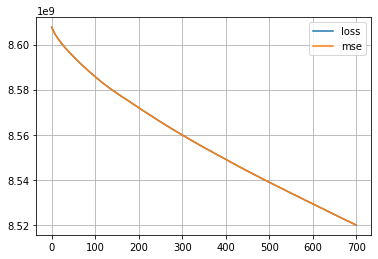

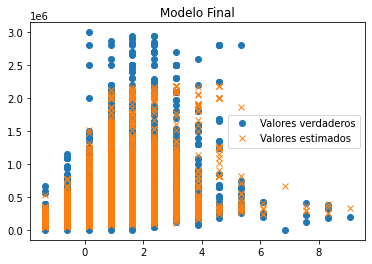

850/850 [==============================] - 4s 5ms/step


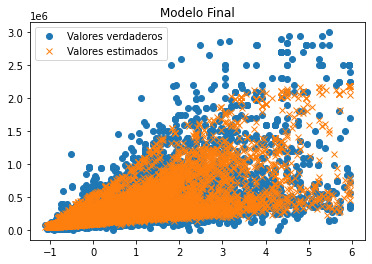

850/850 [==============================] - 2s 2ms/step


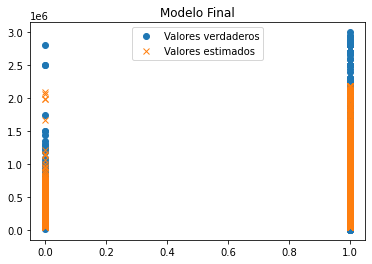

850/850 [==============================] - 1s 2ms/step


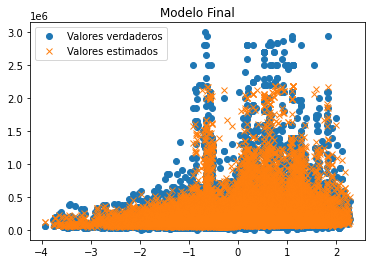

In [278]:
hist = pd.DataFrame(red_reg_historia.history)
hist['epoch'] = red_reg_historia.epoch
hist.tail()
plot_loss(red_reg_historia)
plot_regression(red_reg,x_test_redes_reg,y_test,title=f"Modelo Final",xlabel="sup total",ylabel="price")

##Clasificacion

Procedemos a escalar las variables para realizar el metodo de clasificacion. 

In [279]:
x_train_target_escalado_clas, x_test_target_escalado_clas = escalar_variable('property_surface_total', ds_train =x_train_redes_clas, ds_test = x_test_redes_clas)
x_train_target_escalado_clas, x_test_target_escalado_clas = escalar_variable('property_surface_covered', ds_train =x_train_redes_clas, ds_test = x_test_redes_clas)
x_train_target_escalado_clas, x_test_target_escalado_clas = escalar_variable('latitud', ds_train =x_train_redes_clas, ds_test = x_test_redes_clas)
x_train_target_escalado_clas, x_test_target_escalado_clas = escalar_variable('longitud', ds_train =x_train_redes_clas, ds_test = x_test_redes_clas)
x_train_target_escalado_clas, x_test_target_escalado_clas = escalar_variable('property_rooms', ds_train =x_train_redes_clas, ds_test = x_test_redes_clas)
x_train_target_escalado_clas, x_test_target_escalado_clas = escalar_variable('property_bedrooms', ds_train =x_train_redes_clas, ds_test = x_test_redes_clas)

Creamos la red neuronal.

In [280]:
red_clas = keras.Sequential()
red_clas.add(layers.Dense(71, activation='relu', input_dim=8))
red_clas.add(layers.Dense(24, activation='relu'))
red_clas.add(layers.Dense(17, activation='relu'))
red_clas.add(layers.Dense(6, activation='relu'))
red_clas.add(layers.Dense(3, activation='softmax'))

red_clas.compile(optimizer='adam', #adadelta el mas rapido
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

red_clas.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 71)                639       
                                                                 
 dense_18 (Dense)            (None, 24)                1728      
                                                                 
 dense_19 (Dense)            (None, 17)                425       
                                                                 
 dense_20 (Dense)            (None, 6)                 108       
                                                                 
 dense_21 (Dense)            (None, 3)                 21        
                                                                 
Total params: 2,921
Trainable params: 2,921
Non-trainable params: 0
_________________________________________________________________


Repitiendo el analisis realizado en regresion, podemos concluir en que con un epoch igual a 15 y un batch size igual a 400, se pueden obtener los mejores resultados. 

In [282]:
historia_red_clas=red_clas.fit(x_train_target_escalado_clas,y_train_target,epochs=15,batch_size=400,verbose=False)

In [283]:
y_predic_red_clas = red_clas.predict(x_test_target_escalado_clas)

850/850 [==============================] - 1s 2ms/step


In [284]:
y_predic_red_clas_clases=np.argmax(y_predic_red_clas,axis=1).tolist()

In [285]:
y_test_target_clases = y_test_target.replace(to_replace=['high_price','low_price', 'medium_price'],value=[0,1,2],inplace=False)

In [286]:
from sklearn.metrics import f1_score,  recall_score, precision_score, accuracy_score

print("Accuracy: ", accuracy_score(y_test_target_clases, y_predic_red_clas_clases))
print("Precision: " ,precision_score(y_test_target_clases, y_predic_red_clas_clases, average="macro"))
print("Recall: ",recall_score(y_test_target_clases, y_predic_red_clas_clases , average="macro"))
print("f1_score: ",f1_score(y_test_target_clases, y_predic_red_clas_clases, average="macro"))

Accuracy:  0.633149374540103
Precision:  0.6526260408944845
Recall:  0.5868828692942235
f1_score:  0.6065529914425908


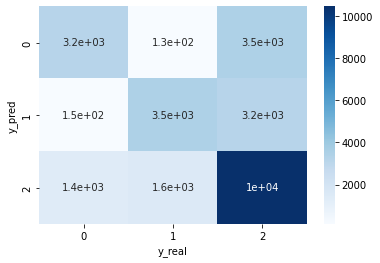

In [287]:
ds_validation=pd.DataFrame(y_predic_red_clas_clases,y_test_target_clases).reset_index()
ds_validation.columns=['y_pred','y_real']

tabla_iris=pd.crosstab(ds_validation.y_pred, ds_validation.y_real)
grf=sns.heatmap(tabla_iris,annot=True, cmap = 'Blues')
plt.show()

#Ensambles

Creamos los datasets con los features del tp1 y con los nuevos. 

In [ ]:
columnas_tp1 = ['property_rooms', 'property_bedrooms', 'property_surface_total','property_surface_covered', 'latitud', 'longitud',
                   'property_type_Departamento','property_type_PH']

columnas_fn = ['property_rooms', 'property_bedrooms', 'property_surface_total','property_surface_covered', 'latitud', 'longitud', 'property_type_Departamento',
            'property_type_PH', 'amenities', 'piso', 'comuna', 'tiene_patio_o_balcon', 'esta_cerca_de_av', 'suite', 'palier', 'vestidor', 'toilette', 'recepción', 'playroom']

x_train_ensamble_tp1 = train_con_dummi[columnas_tp1]
x_test_ensamble_tp1  = test_con_dummi[columnas_tp1]

x_train_ensamble_fn = train_features_nuevos_con_dummi[columnas_fn]
x_test_ensamble_fn = test_features_nuevos_con_dummi[columnas_fn]

y_train_ensamble = train_con_dummi['tipo_precio_generico'].copy()
y_test_ensamble = test_con_dummi['tipo_precio_generico'].copy()

In [ ]:
def identificar_clasificacion(y_pred, tabla):
  counts = collections.Counter(y_pred)
  
  claves = list(counts.keys())
  claves[0]

  clase_0 = tabla[0][0]+tabla[1][0]+tabla[2][0]
  clase_1 = tabla[0][1]+tabla[1][1]+tabla[2][1]
  clase_2 = tabla[0][2]+tabla[1][2]+tabla[2][2]

  lista = ['a', 'b', 'c']

  for i in range(len(claves)):  
    if(counts[claves[i]] == clase_0):
      lista[0] = claves[i]
    elif(counts[claves[i]] == clase_1):
      lista[1] = claves[i]
    else:
      lista[2] = claves[i]

  return lista

##Voting


###Dataset con features nuevos

Realizamos Cross Validation y Random Search para cada uno de los tres clasificadores: arbol de decision, random forest y adaboost. De esta forma, buscamos encontrar los mejores parametros para hallar el mejor ensamble. 

In [ ]:
#Clasificador
dt_fn = DecisionTreeClassifier()

#Metrica
dt_scorer_fn = make_scorer(sk.metrics.f1_score, average = 'macro')

dt_randomcv_fn = cross_validation_function(x_train_ensamble_fn, y_train_ensamble, base_tree=dt_fn, scorer=dt_scorer_fn)

#Creo el árbol con los mejores hiperparámetros
dt_fn=DecisionTreeClassifier(random_state=2).set_params(**dt_randomcv_fn.best_params_)

In [ ]:
#Clasificador
rmf_fn = RandomForestClassifier()

#Metrica
rmf_scorer_fn = make_scorer(sk.metrics.f1_score, average = 'macro') 

rmf_randomcv_fn = cross_validation_function(x_train_ensamble_fn, y_train_ensamble,  base_tree=rmf_fn, scorer=rmf_scorer_fn)

#Creo el árbol con los mejores hiperparámetros
rmf_fn=RandomForestClassifier(random_state=2).set_params(**rmf_randomcv_fn.best_params_)

In [ ]:
#Clasificador
ab_fn = AdaBoostClassifier()

# Metrica
ab_scorer_fn = make_scorer(sk.metrics.f1_score, average = 'macro')

ab_params_grid_fn = {'learning_rate':np.linspace(0.01,0.1,10),
               'n_estimators': list(range(1,100))}

ab_randomcv_fn = cross_validation_function(x_train_ensamble_fn, y_train_ensamble, base_tree=ab_fn, scorer=ab_scorer_fn, params_grid=ab_params_grid_fn)

ab_fn=AdaBoostClassifier(random_state=2).set_params(**ab_randomcv_fn.best_params_)

In [ ]:
vot_clf_fn = VotingClassifier(estimators = [('randomforest', rmf_fn), ('dtree', dt_fn), ('adaboost', ab_fn)], voting = 'soft')

In [ ]:
vot_clf_fn

VotingClassifier(estimators=[('randomforest',
                              RandomForestClassifier(ccp_alpha=0.005555555555555556,
                                                     criterion='entropy',
                                                     max_depth=9,
                                                     random_state=2)),
                             ('dtree',
                              DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=5,
                                                     random_state=2)),
                             ('adaboost',
                              AdaBoostClassifier(learning_rate=0.1,
                                                 n_estimators=84,
                                                 random_state=2))],
                 voting='soft')

Observamos los hiperparametros conseguidos para cada uno de los modelos utilizados en este ensable, mediante la tecnica de Cross Validation.

Paso siguiente, entrenamos el ensamble y evaluamos el conjunto de test.

In [ ]:
vot_clf_fn.fit(x_train_ensamble_fn, y_train_ensamble)
y_pred_vot_fn = vot_clf_fn.predict(x_test_ensamble_fn)

In [ ]:
vot_accuracy_fn=accuracy_score(y_test_ensamble,y_pred_vot_fn)
vot_recall_fn=recall_score(y_test_ensamble,y_pred_vot_fn, average='macro')
vot_f1_fn=f1_score(y_test_ensamble,y_pred_vot_fn, average='macro')

print("Accuracy: "+str(vot_accuracy_fn))
print("Recall: "+str(vot_recall_fn))
print("f1 score: "+str(vot_f1_fn))

Accuracy: 0.60813097866078
Recall: 0.5486314883430544
f1 score: 0.5692665713963133


[Text(32.09375, 0.5, 'True'), Text(0.5, 14.09375, 'Predicted')]

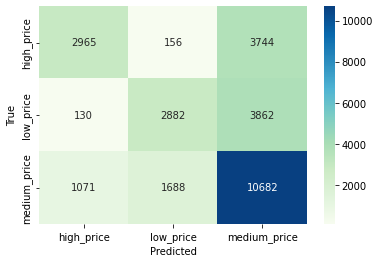

In [ ]:
#Creo la matriz de confusión
vot_tabla_fn=confusion_matrix(y_test_ensamble, y_pred_vot_fn)
vot_columnas_fn=identificar_clasificacion(y_pred_vot_fn,vot_tabla_fn)

#Grafico la matriz de confusión
sns.heatmap(vot_tabla_fn,cmap='GnBu',annot=True,fmt='g', yticklabels = vot_columnas_fn, xticklabels = vot_columnas_fn).set(xlabel="Predicted", ylabel="True")

Podemos concluir en que en el medium_price se predice mucho mejor que en el caso de low_price y high_price. 
Esto se lo podemos atribuir al hecho de que predomina la cantidad de registros con medium_price en el dataset de train. 

###Dataset con features TP1

Realizamos el mismo procedimiento anterior con los features del TP1.

In [ ]:
#Clasificador
dt_tp1 = DecisionTreeClassifier()

#Metrica
dt_scorer_tp1 = make_scorer(sk.metrics.f1_score, average = 'macro')

dt_randomcv_tp1 = cross_validation_function(x_train_ensamble_tp1, y_train_ensamble, base_tree=dt_tp1, scorer=dt_scorer_tp1)

#Creo el árbol con los mejores hiperparámetros
dt_tp1=DecisionTreeClassifier(random_state=2).set_params(**dt_randomcv_tp1.best_params_)

In [ ]:
#Clasificador
rmf_tp1 = RandomForestClassifier()

#Metrica
rmf_scorer_tp1 = make_scorer(sk.metrics.f1_score, average = 'macro') 

rmf_randomcv_tp1 = cross_validation_function(x_train_ensamble_tp1, y_train_ensamble,  base_tree=rmf_tp1, scorer=rmf_scorer_tp1)

#Creo el árbol con los mejores hiperparámetros
rmf_tp1=RandomForestClassifier(random_state=2).set_params(**rmf_randomcv_tp1.best_params_)

In [ ]:
#Clasificador
ab_tp1 = AdaBoostClassifier()

# Metrica
ab_scorer_tp1 = make_scorer(sk.metrics.f1_score, average = 'macro')

ab_params_grid_tp1 = {'learning_rate':np.linspace(0.01,0.1,10),
               'n_estimators': list(range(1,100))}

ab_randomcv_tp1 = cross_validation_function(x_train_ensamble_tp1, y_train_ensamble, base_tree=ab_tp1, scorer=ab_scorer_tp1, params_grid=ab_params_grid_tp1)

ab_tp1=AdaBoostClassifier(random_state=2).set_params(**ab_randomcv_tp1.best_params_)

In [ ]:
vot_clf_tp1 = VotingClassifier(estimators = [('randomforest', rmf_tp1), ('dtree', dt_tp1), ('adaboost', ab_tp1)], voting = 'soft')

In [ ]:
vot_clf_tp1

VotingClassifier(estimators=[('randomforest',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=5,
                                                     random_state=2)),
                             ('dtree',
                              DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=5,
                                                     random_state=2)),
                             ('adaboost',
                              AdaBoostClassifier(learning_rate=0.1,
                                                 n_estimators=84,
                                                 random_state=2))],
                 voting='soft')

Observamos los hiperparametros conseguidos para cada uno de los modelos utilizados en este ensable, mediante la tecnica de Cross Validation.

Paso siguiente, entrenamos el ensamble y evaluamos el conjunto de test.

In [ ]:
vot_clf_tp1.fit(x_train_ensamble_tp1, y_train_ensamble)
y_pred_vot_tp1 = vot_clf_tp1.predict(x_test_ensamble_tp1)

In [ ]:
vot_accuracy_tp1=accuracy_score(y_test_target,y_pred_vot_tp1)
vot_recall_tp1=recall_score(y_test_target,y_pred_vot_tp1, average='macro')
vot_f1_tp1=f1_score(y_test_target,y_pred_vot_tp1, average='macro')

print("Accuracy: "+str(vot_accuracy_tp1))
print("Recall: "+str(vot_recall_tp1))
print("f1 score: "+str(vot_f1_tp1))

Accuracy: 0.5838852097130243
Recall: 0.5065272837896727
f1 score: 0.522733325552808


[Text(32.09375, 0.5, 'True'), Text(0.5, 14.09375, 'Predicted')]

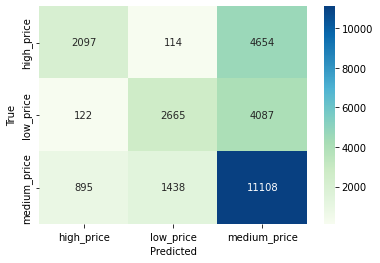

In [ ]:
#Creo la matriz de confusión
vot_tabla_tp1=confusion_matrix(y_test_ensamble, y_pred_vot_tp1)
vot_columnas_tp1=identificar_clasificacion(y_pred_vot_tp1,vot_tabla_tp1)

#Grafico la matriz de confusión
sns.heatmap(vot_tabla_tp1,cmap='GnBu',annot=True,fmt='g', yticklabels = vot_columnas_tp1, xticklabels = vot_columnas_tp1).set(xlabel="Predicted", ylabel="True")

### Conclusion en Voting


In [ ]:
print("Accuracy con features nuevos: "+str(vot_accuracy_fn))
print("Recall con features nuevos: "+str(vot_recall_fn))
print("f1 score con features nuevos: "+str(vot_f1_fn))

print("Accuracy: "+str(vot_accuracy_tp1))
print("Recall: "+str(vot_recall_tp1))
print("f1 score: "+str(vot_f1_tp1))

print("Diferencia en Accuracy al agregar features nuevos: "+str(vot_accuracy_fn - vot_accuracy_tp1))
print("Diferencia en Recall al agregar features nuevos: "+str(vot_recall_fn - vot_recall_tp1))
print("Diferencia en f1 score al agregar features nuevos: "+str(vot_f1_fn - vot_f1_tp1))

Accuracy con features nuevos: 0.60813097866078
Recall con features nuevos: 0.5486314883430544
f1 score con features nuevos: 0.5692665713963133
Accuracy: 0.5838852097130243
Recall: 0.5065272837896727
f1 score: 0.522733325552808
Diferencia en Accuracy al agregar features nuevos: 0.024245768947755764
Diferencia en Recall al agregar features nuevos: 0.04210420455338171
Diferencia en f1 score al agregar features nuevos: 0.046533245843505266


Se puede observar una mejora en las metricas del ensamble al utilizar los features:
* Piso 
* Amentinies 
* Estar cerca de avenida
* Booleano al tener: 
    * Patio o balcon 
    * Palier 
    * Vestidor 
    * Suite 
    * Toilette
    * Recepcion
    * Playroom

Esto ultimo tiene sentido, siendo que se estaria utilizando informacion que todo comprador considera relevante.

##Stacking

Procedemos a crear un ensamble de tipo Stacking

In [ ]:
#Funcion para evaluar los modelos 5fold -CV (repite 2 veces)
def evaluate_model(model, x, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
    scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, verbose=1, n_jobs=3, error_score='raise')
    return scores

In [ ]:
#Funcion para plotear a performance
def plot_results(model_scores, name):
    
    model_names = list(model_scores.keys())
    results = [model_scores[model] for model in model_names]
    fig = go.Figure()
    for model, result in zip(model_names, results):
        fig.add_trace(go.Box(
            y=result,
            name=model,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            marker_size=2,
            line_width=1)
        )
    

    fig.update_layout(
    title='Performance of Different Models Using 5-Fold Cross-Validation',
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    xaxis_title='Model',
    yaxis_title='Accuracy',
    showlegend=False)
    fig.show()

### Dataset con features nuevos

In [ ]:
#Clasificador
dt_st_fn = DecisionTreeClassifier()

#Metrica
dt_st_scorer_fn = make_scorer(sk.metrics.f1_score, average = 'macro')

dt_st_randomcv_fn = cross_validation_function(x_train_ensamble_fn, y_train_ensamble, base_tree=dt_st_fn, scorer=dt_st_scorer_fn)

#Creo el árbol con los mejores hiperparámetros
dt_st_fn=DecisionTreeClassifier(random_state=2).set_params(**dt_st_randomcv_fn.best_params_)

In [ ]:
#Clasificador
rmf_st_fn = RandomForestClassifier()

#Metrica
rmf_st_scorer_fn = make_scorer(sk.metrics.f1_score, average = 'macro') 

rmf_st_randomcv_fn = cross_validation_function(x_train_ensamble_fn, y_train_ensamble,  base_tree=rmf_st_fn, scorer=rmf_st_scorer_fn)

#Creo el árbol con los mejores hiperparámetros
rmf_st_fn=RandomForestClassifier(random_state=2).set_params(**rmf_st_randomcv_fn.best_params_)

In [ ]:
#Clasificador
ab_st_fn = AdaBoostClassifier()

# Metrica
ab_st_scorer_fn = make_scorer(sk.metrics.f1_score, average = 'macro')

ab_st_params_grid_fn = {'learning_rate':np.linspace(0.01,0.1,10),
               'n_estimators': list(range(1,100))}

ab_st_randomcv_fn = cross_validation_function(x_train_ensamble_fn, y_train_ensamble, base_tree=ab_st_fn, scorer=ab_st_scorer_fn, params_grid=ab_st_params_grid_fn)

ab_st_fn=AdaBoostClassifier(random_state=2).set_params(**ab_st_randomcv_fn.best_params_)

In [ ]:
#Modelos Base
base_models_st_fn = {'random_forest':RandomForestClassifier(random_state=2).set_params(**rmf_st_randomcv_fn.best_params_),
               'adab_stoost': AdaBoostClassifier(random_state=2).set_params(**ab_st_randomcv_fn.best_params_),
               'DecisionTree': DecisionTreeClassifier(random_state=2).set_params(**dt_st_randomcv_fn.best_params_)}

#Guarda los scores de cada modelo
model_scores_st_fn = defaultdict()

#Entreno los clasificadores
for name, model in base_models_st_fn.items():
    print('Evaluating {}'.format(name))
    scores = evaluate_model(model, x_train_ensamble_fn, y_train_ensamble)
    model_scores_st_fn[name] = scores

Evaluating random_forest


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   53.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating adab_stoost


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  1.4min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating DecisionTree


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.4s finished


Utilizaremos modelos de random forest, adab_stoost y decision tree para el ensamble. Como modelo de salida utilizaremos LogisticRegressionCV.

In [ ]:
from sklearn.ensemble import StackingClassifier

# #Modelos Base
base_models_st_fn = [('random_forest',RandomForestClassifier(random_state=2).set_params(**rmf_st_randomcv_fn.best_params_)),
               ('adab_stoost', AdaBoostClassifier(random_state=2).set_params(**ab_st_randomcv_fn.best_params_)),
               ('DecisionTree', DecisionTreeClassifier(random_state=2).set_params(**dt_st_randomcv_fn.best_params_))]

#Meta Modelo
meta_model = LogisticRegressionCV()

#Ensemble Stacking
st_clf_fn = StackingClassifier(estimators=base_models_st_fn, 
                                    final_estimator=meta_model, 
                                    passthrough=True, 
                                    cv=5,
                                    verbose=2)

In [ ]:
#Performance el modelo en entrenamiento
stacking_scores = evaluate_model(st_clf_fn, x_train_ensamble_fn, y_train_ensamble)
model_scores_st_fn['stacking'] = stacking_scores

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed: 21.7min finished


Observamos las metricas de los distintos modelos dentro del ensamble.

In [ ]:
model_scores_st_fn

defaultdict(None,
            {'random_forest': array([0.59665457, 0.61188259, 0.59472895, 0.59512349, 0.59780636,
                    0.59736468, 0.60351902, 0.59433441, 0.60206739, 0.60001578]),
             'adab_stoost': array([0.5653306 , 0.56588291, 0.56442831, 0.56498067, 0.56371814,
                    0.56840776, 0.56848667, 0.56458613, 0.56442831, 0.56253452]),
             'DecisionTree': array([0.59744359, 0.60848982, 0.60246193, 0.61129961, 0.60940582,
                    0.60225659, 0.612356  , 0.6091691 , 0.60246193, 0.60396118]),
             'stacking': array([0.62403345, 0.6357109 , 0.62526631, 0.640101  , 0.63236803,
                    0.63121351, 0.63752564, 0.63173676, 0.63134222, 0.62660775])})

In [ ]:
#Grafico performance
plot_results(model_scores_st_fn, name='st_clf_fn_cv')

Analizando el grafico, vemos el resultado que se mencionaba en las clases: muchos modelos mediocres juntos pueden resultar en un modelo mucho mejor. 

Como observamos, las metricas de cada uno de los modelos no pasa de 0.62, al contrario de la metrica final del ensamble.

Habiendo hecho este analisis, procedemos a entrenar el modelo y predecir con el mismo. 

In [ ]:
#Evaluo en conjunto de test
st_clf_fn.fit(x_train_ensamble_fn,y_train_ensamble).score(x_test_ensamble_fn,y_test_ensamble)
y_pred_st_fn = st_clf_fn.predict(x_test_ensamble_fn)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   29.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished


In [ ]:
st_accuracy_nuevos=accuracy_score(y_test_target,y_pred_st_fn)
st_recall_nuevos=recall_score(y_test_target,y_pred_st_fn, average='macro')
st_f1_nuevos=f1_score(y_test_target,y_pred_st_fn, average='macro')

print("Accuracy: "+str(st_accuracy_nuevos))
print("Recall: "+str(st_recall_nuevos))
print("f1 score: "+str(st_f1_nuevos))

Accuracy: 0.6330389992641648
Recall: 0.581219091118423
f1 score: 0.6027942050914362


Obtenemos la siguiente metrica de accuracy.

In [ ]:
print("Accuracy obtenida con el ensamble de stackig: ", accuracy_score(y_test_ensamble, y_pred_st_fn))

Accuracy obtenida con el ensamble de stackig:  0.6330389992641648


Analicemos la matriz de confusion obtenida luego de las predicciones.

In [ ]:
y_test_ensamble

0           low_price
1          high_price
2           low_price
3        medium_price
4           low_price
             ...     
27175    medium_price
27176       low_price
27177       low_price
27178    medium_price
27179       low_price
Name: tipo_precio_generico, Length: 27180, dtype: object

[Text(32.09375, 0.5, 'True'), Text(0.5, 14.09375, 'Predicted')]

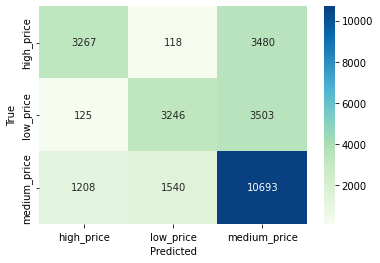

In [ ]:
#Creo la matriz de confusión
st_tabla_fn=confusion_matrix(y_test_ensamble, y_pred_st_fn)
st_columnas=identificar_clasificacion(y_pred_st_fn,st_tabla_fn)

#Grafico la matriz de confusión

sns.heatmap(st_tabla_fn,cmap='GnBu',annot=True,fmt='g', yticklabels = st_columnas, xticklabels = st_columnas).set(xlabel="Predicted", ylabel="True")

### Dataset con features TP1

Realizamos el mismo procedimiento anterior con los features del TP1.

In [ ]:
#Clasificador
dt_st_tp1 = DecisionTreeClassifier()

#Metrica
dt_st_scorer_tp1 = make_scorer(sk.metrics.f1_score, average = 'macro')

dt_st_randomcv_tp1 = cross_validation_function(x_train_ensamble_tp1, y_train_ensamble, base_tree=dt_st_tp1, scorer=dt_st_scorer_tp1)

#Creo el árbol con los mejores hiperparámetros
dt_st_tp1=DecisionTreeClassifier(random_state=2).set_params(**dt_st_randomcv_tp1.best_params_)

In [ ]:
#Clasificador
rmf_st_tp1 = RandomForestClassifier()

#Metrica
rmf_st_scorer_tp1 = make_scorer(sk.metrics.f1_score, average = 'macro') 

rmf_st_randomcv_tp1 = cross_validation_function(x_train_ensamble_tp1, y_train_ensamble,  base_tree=rmf_st_tp1, scorer=rmf_st_scorer_tp1)

#Creo el árbol con los mejores hiperparámetros
rmf_st_tp1=RandomForestClassifier(random_state=2).set_params(**rmf_st_randomcv_tp1.best_params_)

In [ ]:
#Clasificador
ab_st_tp1 = AdaBoostClassifier()

# Metrica
ab_st_scorer_tp1 = make_scorer(sk.metrics.f1_score, average = 'macro')

ab_st_params_grid_tp1 = {'learning_rate':np.linspace(0.01,0.1,10),
               'n_estimators': list(range(1,100))}

ab_st_randomcv_tp1 = cross_validation_function(x_train_ensamble_tp1, y_train_ensamble, base_tree=ab_st_tp1, scorer=ab_st_scorer_tp1, params_grid=ab_st_params_grid_tp1)

ab_st_tp1=AdaBoostClassifier(random_state=2).set_params(**ab_st_randomcv_tp1.best_params_)

In [ ]:
#Modelos Base
base_models_st_tp1 = {'random_forest':RandomForestClassifier(random_state=2).set_params(**rmf_st_randomcv_tp1.best_params_),
               'adab_stoost': AdaBoostClassifier(random_state=2).set_params(**ab_st_randomcv_tp1.best_params_),
               'DecisionTree': DecisionTreeClassifier(random_state=2).set_params(**dt_st_randomcv_tp1.best_params_)}

#Guarda los scores de cada modelo
model_scores_st_tp1 = defaultdict()

#Entreno los clasificadores
for name, model in base_models_st_tp1.items():
    print('Evaluating {}'.format(name))
    scores = evaluate_model(model, x_train_ensamble_tp1, y_train_ensamble)
    model_scores_st_tp1[name] = scores

Evaluating random_forest


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   30.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating adab_stoost


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  1.3min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating DecisionTree


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.1s finished


Utilizaremos modelos de random forest, adab_stoost y decision tree para el ensamble. Como modelo de salida utilizaremos LogisticRegressionCV.

In [ ]:
from sklearn.ensemble import StackingClassifier

# #Modelos Base
base_models_st_tp1 = [('random_forest',RandomForestClassifier(random_state=2).set_params(**rmf_st_randomcv_tp1.best_params_)),
               ('adab_stoost', AdaBoostClassifier(random_state=2).set_params(**ab_st_randomcv_tp1.best_params_)),
               ('DecisionTree', DecisionTreeClassifier(random_state=2).set_params(**dt_st_randomcv_tp1.best_params_))]

#Meta Modelo
meta_model = LogisticRegressionCV()

#Ensemble Stacking
st_clf_tp1 = StackingClassifier(estimators=base_models_st_tp1, 
                                    final_estimator=meta_model, 
                                    passthrough=True, 
                                    cv=5,
                                    verbose=2)

In [ ]:
#Performance el modelo en entrenamiento
stacking_scores = evaluate_model(st_clf_tp1, x_train_ensamble_tp1, y_train_ensamble)
model_scores_st_tp1['stacking'] = stacking_scores

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed: 17.8min finished


Observamos las metricas de los distintos modelos dentro del ensamble.

In [ ]:
model_scores_st_tp1

defaultdict(None,
            {'random_forest': array([0.57566672, 0.584267  , 0.57350272, 0.57476525, 0.5753176 ,
                    0.57574562, 0.57527221, 0.57437071, 0.57705358, 0.57208238]),
             'adab_stoost': array([0.55033928, 0.55041818, 0.55314448, 0.55274994, 0.54485915,
                    0.55459997, 0.55199621, 0.5523554 , 0.54998816, 0.54983035]),
             'DecisionTree': array([0.58174215, 0.58947451, 0.58257713, 0.58557563, 0.59015229,
                    0.57748146, 0.59065804, 0.5812357 , 0.58857413, 0.58415529]),
             'stacking': array([0.60557046, 0.62316554, 0.60569715, 0.61082617, 0.61051053,
                    0.60123087, 0.62032507, 0.60372445, 0.61382467, 0.61271996])})

In [ ]:
#Grafico performance
plot_results(model_scores_st_tp1, name='st_clf_tp1_cv')

Vemos el resultado que se mencionab_sta en las clases de como muchos modelos mediocres, juntos, podrían resultar en un modelo mucho mejor. Como observamos, las metricas de cada uno de los modelos no pasa el 0.62, no como la metrica final del ensamble.

Habiendo hecho este analisis, procedemos a entrenar el modelo y predecir con el mismo. 

In [ ]:
#Evaluo en conjunto de test
st_clf_tp1.fit(x_train_ensamble_tp1,y_train_ensamble).score(x_test_ensamble_tp1,y_test_ensamble)
y_pred_st_tp1 = st_clf_tp1.predict(x_test_ensamble_tp1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   19.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   17.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished


In [ ]:
st_accuracy_tp1=accuracy_score(y_test_target,y_pred_st_tp1)
st_recall_tp1=recall_score(y_test_target,y_pred_st_tp1, average='macro')
st_f1_tp1=f1_score(y_test_target,y_pred_st_tp1, average='macro')

print("Accuracy: "+str(st_accuracy_tp1))
print("Recall: "+str(st_recall_tp1))
print("f1 score: "+str(st_f1_tp1))

Accuracy: 0.6122516556291391
Recall: 0.5564235964392118
f1 score: 0.5764413487607402


Obtenemos la siguiente metrica de accuracy.

In [ ]:
print("Accuracy obtenida con el ensamble de stackig: ", accuracy_score(y_test_ensamble, y_pred_st_tp1))

Accuracy obtenida con el ensamble de stackig:  0.6122516556291391


Analicemos la matriz de confusion obtenida luego de las predicciones.

[Text(32.09375, 0.5, 'True'), Text(0.5, 14.09375, 'Predicted')]

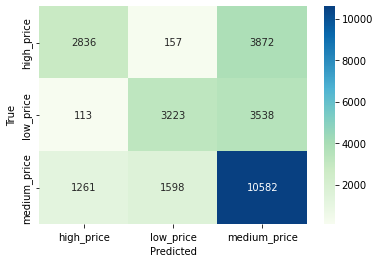

In [ ]:
#Creo la matriz de confusión
st_tabla_tp1=confusion_matrix(y_test_ensamble, y_pred_st_tp1)
st_columnas=identificar_clasificacion(y_pred_st_tp1,st_tabla_tp1)

#Grafico la matriz de confusión
sns.heatmap(st_tabla_tp1,cmap='GnBu',annot=True,fmt='g', yticklabels = st_columnas, xticklabels = st_columnas).set(xlabel="Predicted", ylabel="True")

### Conclusion de Stacking

In [ ]:
print("Accuracy con features nuevos: "+str(st_accuracy_nuevos))
print("Recall con features nuevos: "+str(st_recall_nuevos))
print("f1 score con features nuevos: "+str(st_f1_nuevos))

print("Accuracy: "+str(st_accuracy_tp1))
print("Recall: "+str(st_recall_tp1))
print("f1 score: "+str(st_f1_tp1))

print("Diferencia en Accuracy al agregar features nuevos: "+str(st_accuracy_nuevos - st_accuracy_tp1))
print("Diferencia en Recall al agregar features nuevos: "+str(st_recall_nuevos - st_recall_tp1))
print("Diferencia en f1 score al agregar features nuevos: "+str(st_f1_nuevos - st_f1_tp1))

Accuracy con features nuevos: 0.6330389992641648
Recall con features nuevos: 0.581219091118423
f1 score con features nuevos: 0.6027942050914362
Accuracy: 0.6122516556291391
Recall: 0.5564235964392118
f1 score: 0.5764413487607402
Diferencia en Accuracy al agregar features nuevos: 0.020787343635025768
Diferencia en Recall al agregar features nuevos: 0.02479549467921116
Diferencia en f1 score al agregar features nuevos: 0.02635285633069606


# Conclusion general

XGBoost:

In [288]:
print("------------------------------------------------------------------------------------")
print("Metricas utilizando el dataset del tp1")
calcular_metricas_de_regresion(xgb_y_pred)
print("----------------------------------------------------------")
print("Metricas utilizando el dataset con features nuevos")
calcular_metricas_de_regresion(xgb_y_pred_fn)
print("------------------------------------------------------------------------------------")

------------------------------------------------------------------------------------
Metricas utilizando el dataset del tp1
El error (mse) de test es: 20136158403.007263
El error (rmse) de test es: 141901.93234416246
----------------------------------------------------------
Metricas utilizando el dataset con features nuevos
El error (mse) de test es: 9740892610.387033
El error (rmse) de test es: 98695.9604562772
------------------------------------------------------------------------------------


Redes Neuronales Regresion

In [289]:
print("------------------------------------------------------------------------------------")
print("Metricas de redes neuronales - regresion")
print(f"Error absoluto medio {mae_red_reg}")
print(f"Error cuadrático medio {mse_red_reg}")
print(f"El error (rmse) de test es: {rmse_red_reg}")
print(f"El r2 score es: {r2score_red_reg}")
print("------------------------------------------------------------------------------------")

------------------------------------------------------------------------------------
Metricas de redes neuronales - regresion
Error absoluto medio 45257.09385577631
Error cuadrático medio 8805884848.616373
El error (rmse) de test es: 93839.67630281113
El r2 score es: 0.8572141362176638
------------------------------------------------------------------------------------


Redes Neuronales Clasificacion

In [290]:
print("------------------------------------------------------------------------------------")
print("Metricas de redes neuronales - clasificacion")
print("Accuracy: ", accuracy_score(y_test_target_clases, y_predic_red_clas_clases))
print("Precision: " ,precision_score(y_test_target_clases, y_predic_red_clas_clases, average="macro"))
print("Recall: ",recall_score(y_test_target_clases, y_predic_red_clas_clases , average="macro"))
print("f1_score: ",f1_score(y_test_target_clases, y_predic_red_clas_clases, average="macro"))
print("------------------------------------------------------------------------------------")

------------------------------------------------------------------------------------
Metricas de redes neuronales - clasificacion
Accuracy:  0.633149374540103
Precision:  0.6526260408944845
Recall:  0.5868828692942235
f1_score:  0.6065529914425908
------------------------------------------------------------------------------------


Voting

In [291]:
print("------------------------------------------------------------------------------------")
print("Metricas de ensambles - voting")
print("Accuracy con features nuevos: "+str(vot_accuracy_fn))
print("Recall con features nuevos: "+str(vot_recall_fn))
print("f1 score con features nuevos: "+str(vot_f1_fn))
print("----------------------------------------------------------")
print("Accuracy: "+str(vot_accuracy_tp1))
print("Recall: "+str(vot_recall_tp1))
print("f1 score: "+str(vot_f1_tp1))
print("----------------------------------------------------------")
print("Diferencia en Accuracy al agregar features nuevos: "+str(vot_accuracy_fn - vot_accuracy_tp1))
print("Diferencia en Recall al agregar features nuevos: "+str(vot_recall_fn - vot_recall_tp1))
print("Diferencia en f1 score al agregar features nuevos: "+str(vot_f1_fn - vot_f1_tp1))
print("------------------------------------------------------------------------------------")

------------------------------------------------------------------------------------
Metricas de ensambles - voting
Accuracy con features nuevos: 0.60813097866078
Recall con features nuevos: 0.5486314883430544
f1 score con features nuevos: 0.5692665713963133
----------------------------------------------------------
Accuracy: 0.5838852097130243
Recall: 0.5065272837896727
f1 score: 0.522733325552808
----------------------------------------------------------
Diferencia en Accuracy al agregar features nuevos: 0.024245768947755764
Diferencia en Recall al agregar features nuevos: 0.04210420455338171
Diferencia en f1 score al agregar features nuevos: 0.046533245843505266
------------------------------------------------------------------------------------


Stacking

In [292]:
print("------------------------------------------------------------------------------------")
print("Metricas de ensambles - stacking")
print("Accuracy con features nuevos: "+str(st_accuracy_nuevos))
print("Recall con features nuevos: "+str(st_recall_nuevos))
print("f1 score con features nuevos: "+str(st_f1_nuevos))
print("----------------------------------------------------------")
print("Accuracy: "+str(st_accuracy_tp1))
print("Recall: "+str(st_recall_tp1))
print("f1 score: "+str(st_f1_tp1))
print("----------------------------------------------------------")
print("Diferencia en Accuracy al agregar features nuevos: "+str(st_accuracy_nuevos - st_accuracy_tp1))
print("Diferencia en Recall al agregar features nuevos: "+str(st_recall_nuevos - st_recall_tp1))
print("Diferencia en f1 score al agregar features nuevos: "+str(st_f1_nuevos - st_f1_tp1))
print("------------------------------------------------------------------------------------")

------------------------------------------------------------------------------------
Metricas de ensambles - stacking
Accuracy con features nuevos: 0.6330389992641648
Recall con features nuevos: 0.581219091118423
f1 score con features nuevos: 0.6027942050914362
----------------------------------------------------------
Accuracy: 0.6122516556291391
Recall: 0.5564235964392118
f1 score: 0.5764413487607402
----------------------------------------------------------
Diferencia en Accuracy al agregar features nuevos: 0.020787343635025768
Diferencia en Recall al agregar features nuevos: 0.02479549467921116
Diferencia en f1 score al agregar features nuevos: 0.02635285633069606
------------------------------------------------------------------------------------


En conclusion, con la realizacion de este trabajo practico pudimos estudiar la mejora en el uso de modelos de ciencias de datos al agregagar features impiricamente importantes para la prediccion de alguna caracteristica.

Como podemos observar, todas las metricas de los modelos utilizados a lo largo del trabajo presentan mejores resultados al haber usado los features agregados. De esta manera podemos ver la importancia, y correlacion de los features nuevos con el precio, validando asi el hecho de haberlos considerado para el estudio y prediccion de precios.